In [1]:
import functools
from imposm.parser import OSMParser
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
# import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline

import data_munging

Populating the interactive namespace from numpy and matplotlib


### Ride Report Method

Here, we use the `match` method from the OSRM API with the code modified to return only the endpoints of segments. This allows us to aggregate over OSM segments since the node IDs are uniquely associated with a lat/lon pair given sufficient precision in the returned coordinates. The API recommends not using every single value for the match method, but I'm giving them regardless because it's easier to code. Down-sampling the ride might actually help to smooth some of the rides. (or perhaps not if we accidentally get a jagged part).

Currently, I am unsure how to mark up OSM data with bumpiness information, as we have 
data that look like this in the raw OSM file:


``
        <way id="23642309" version="25" timestamp="2013-12-26T23:03:24Z" changeset="19653154" uid="28775" user="StellanL">
                <nd ref="258965973"/>
                <nd ref="258023463"/>
                <nd ref="736948618"/>
                <nd ref="258023391"/>
                <nd ref="736948622"/>
                <nd ref="930330659"/>
                <nd ref="736861978"/>
                <nd ref="930330542"/>
                <nd ref="930330544"/>
                <nd ref="929808660"/>
                <nd ref="736934948"/>
                <nd ref="930330644"/>
                <nd ref="736871567"/>
                <nd ref="619628331"/>
                <nd ref="740363293"/>
                <nd ref="931468900"/>
                <tag k="name" v="North Wabash Avenue"/>
                <tag k="highway" v="tertiary"/>
                <tag k="loc_ref" v="44 E"/>
        </way>"
``


My tentative idea is to match up the lat/lons with OSM id using IMPOSM, then find the `nd refs` in the original data and add a property that contains bumpiness information.

In [2]:
rides, readings = data_munging.read_raw_data()
# This is here temporarily both to create a static dataset and because
# some of the newer android readings are bogus and need to be removed.
rides = rides.loc[rides['created_at'] < '2016-03-01', :]
readings = readings.loc[readings['created_at'] < '2016-03-01', :]

In [3]:
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

You can get the IP address by linking up to the Docker container running OSRM and pinging it.

In [4]:
url = 'http://162.243.23.60/osrm-chi-vanilla/'
url = 'http://172.17.0.2:5000/'
nearest_request = url + 'nearest?loc={0},{1}'
match_request = url + 'match?loc={0},{1}&t={2}&loc={3},{4}&t={5}'

In [5]:
def readings_to_match_str(readings):
    data_str = '&loc={0},{1}&t={2}'
    output_str = ''
    elapsed_time = 0
    for i, reading in readings.iterrows():
        elapsed_time += 1
        new_str = data_str.format(str(reading['start_lat']), str(reading['start_lon']), str(elapsed_time))
        output_str += new_str
    return url + 'match?' + output_str[1:]

In [6]:
readings_to_match_str(readings.loc[readings['ride_id'] == 128,  :])

'http://172.17.0.2:5000/match?loc=41.9343765406,-87.7126272396&t=1&loc=41.9343547896,-87.7126500384&t=2&loc=41.9343320327,-87.712677531&t=3&loc=41.9343099045,-87.7127067839&t=4&loc=41.934289746,-87.7127305047&t=5&loc=41.9342679112,-87.7127554827&t=6&loc=41.9342436036,-87.7127800417&t=7&loc=41.9342211401,-87.7128013317&t=8&loc=41.9341976708,-87.71282346&t=9&loc=41.9341737824,-87.7128460911&t=10&loc=41.934151738,-87.7128689737&t=11&loc=41.9341278496,-87.7128971369&t=12&loc=41.9341003988,-87.712927647&t=13&loc=41.9340715651,-87.7129613423&t=14&loc=41.9340427313,-87.7129932773&t=15&loc=41.934011844,-87.7130246256&t=16&loc=41.9339807053,-87.7130557225&t=17&loc=41.9339525002,-87.7130850592&t=18&loc=41.9339230797,-87.713117078&t=19&loc=41.9338936592,-87.7131512762&t=20&loc=41.9338654541,-87.7131827921&t=21&loc=41.9338368299,-87.7132167389&t=22&loc=41.9338079123,-87.7132548765&t=23&loc=41.9337800425,-87.713291254&t=24&loc=41.9337512087,-87.7133262903&t=25&loc=41.9337217883,-87.7133589798&t=26&

In [7]:
matched_ride = requests.get(readings_to_match_str(readings.loc[readings['ride_id'] == 128,  :])).json()

In [8]:
snapped_points =  pd.DataFrame(matched_ride['matchings'][0]['matched_points'], columns=['lat', 'lon'])

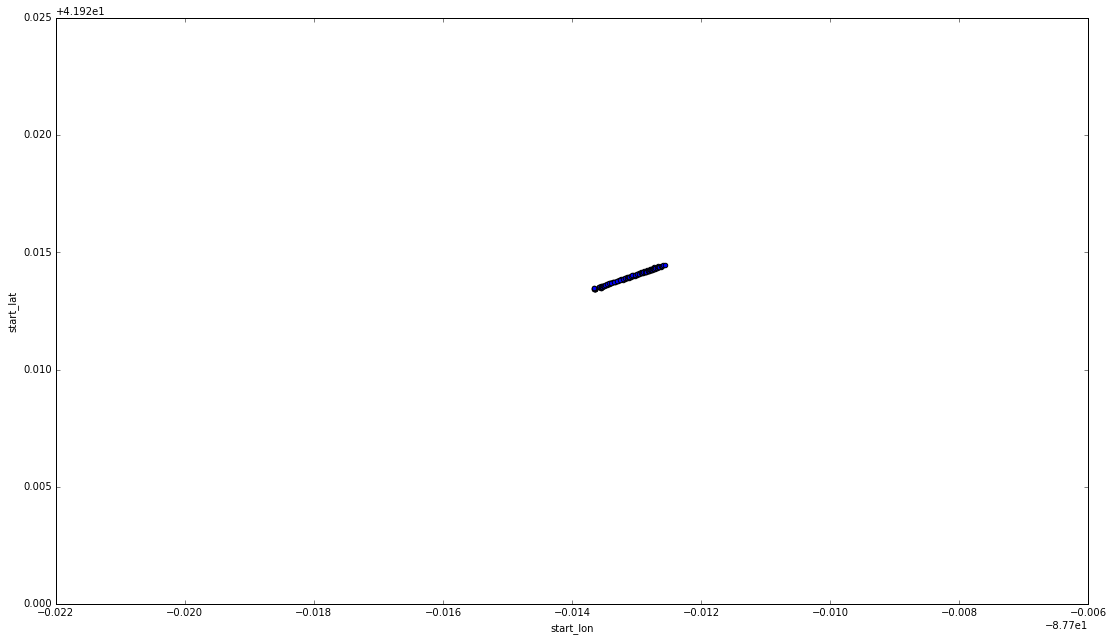

In [9]:
ax = snapped_points.plot(x='lon', y='lat', kind='scatter')
readings.loc[readings['ride_id'] == 128,  :].plot(x='start_lon', y='start_lat', kind='scatter', ax=ax)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [10]:
a_reading = readings.loc[0, :]
test_match_request = match_request.format(a_reading['start_lat'],
                                      a_reading['start_lon'], 
                                      0,
                                      a_reading['end_lat'],
                                      a_reading['end_lon'],
                                      1)
# This does not work because OSRM does not accept floats as times. 
# test_map_request = map_request.format(*tuple(a_reading[['start_lat', 'start_lon', 'start_time',
#                                                 'end_lat', 'end_lon', 'end_time']]))

In [11]:
test_nearest_request = nearest_request.format(a_reading['start_lat'], a_reading['start_lon'])

In [12]:
osrm_response = requests.get(test_match_request).json()
osrm_response['matchings'][0]['matched_points']

[[41.896751, -87.634209], [41.896713, -87.634209]]

In [13]:
osrm_response = requests.get(test_nearest_request).json()
osrm_response['mapped_coordinate']

[41.896751, -87.634209]

In [14]:
readings['snapped_lat'] = 0
readings['snapped_lon'] = 0

In [15]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     nearest_request = nearest_request.format(reading['start_lat'], reading['end_lat'])
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [16]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']])
# #     print i
# #     print data 
#     osrm_request = nearest_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     readings.loc[i, ['snapped_lat', 'snapped_lon']] = osrm_response['mapped_coordinate']
# #     print osrm_response
#     total_calls += 1
#     if total_calls % 1000 == 0:
#         print(total_calls)

In [17]:
chi_readings = data_munging.filter_readings_to_chicago(readings)
chi_rides = list(set(chi_readings.ride_id))

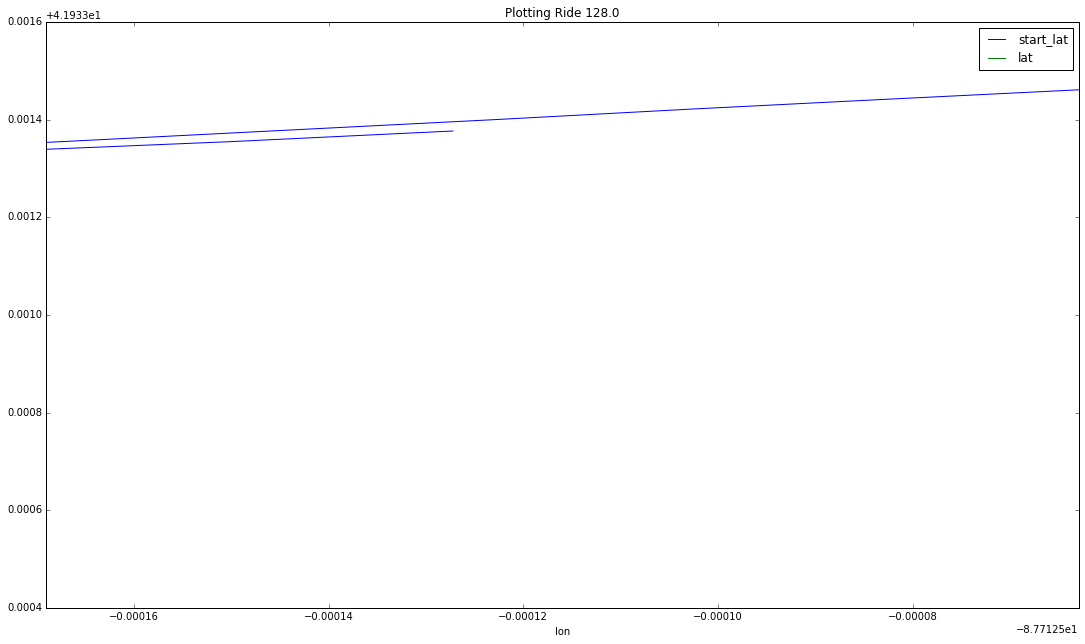

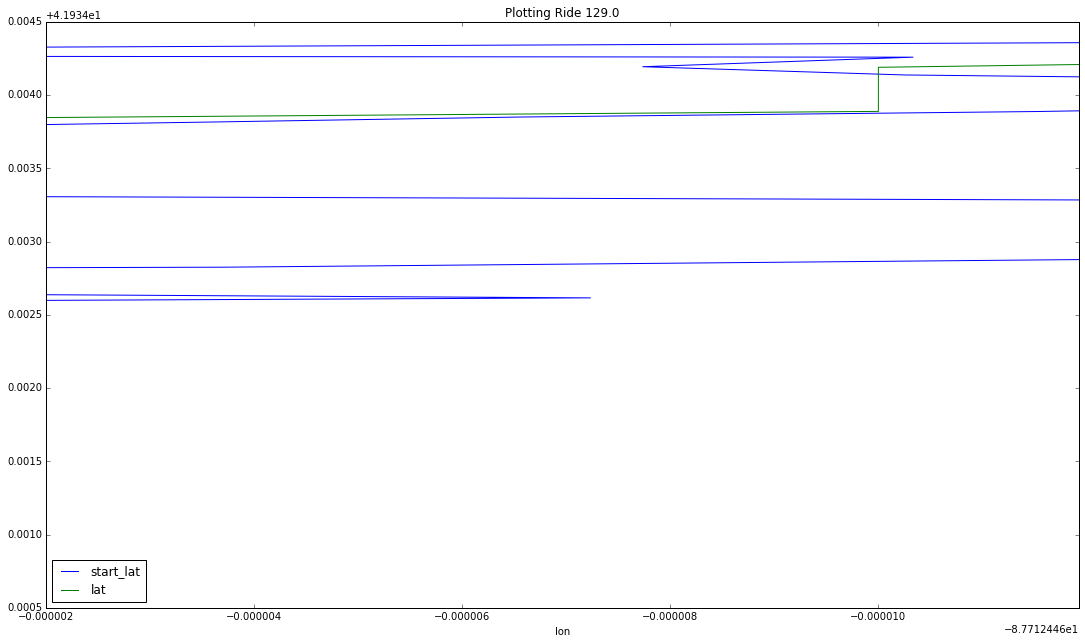

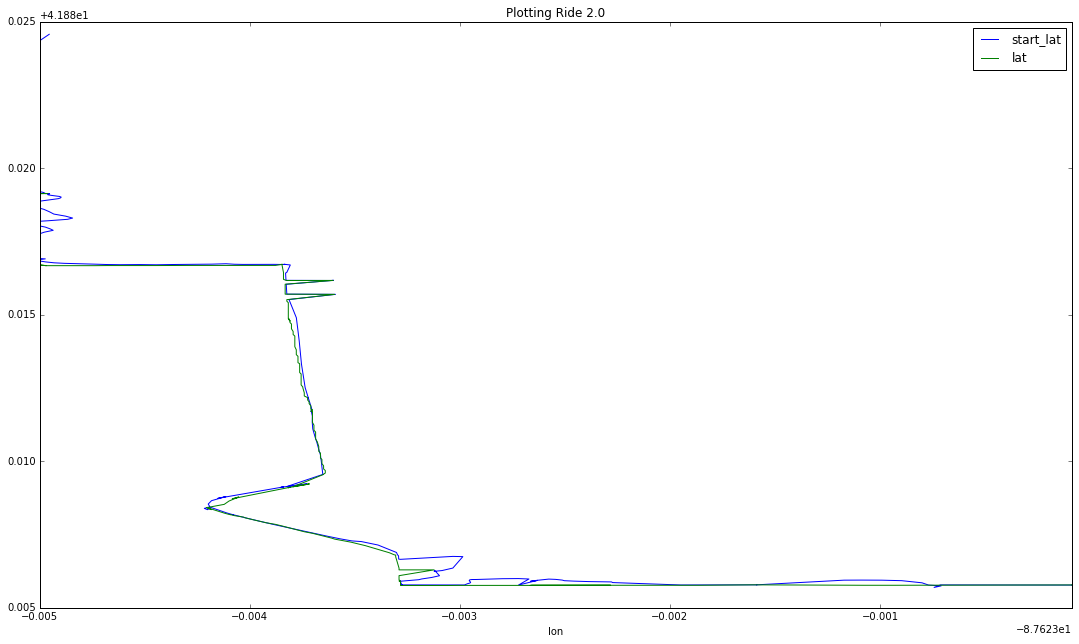

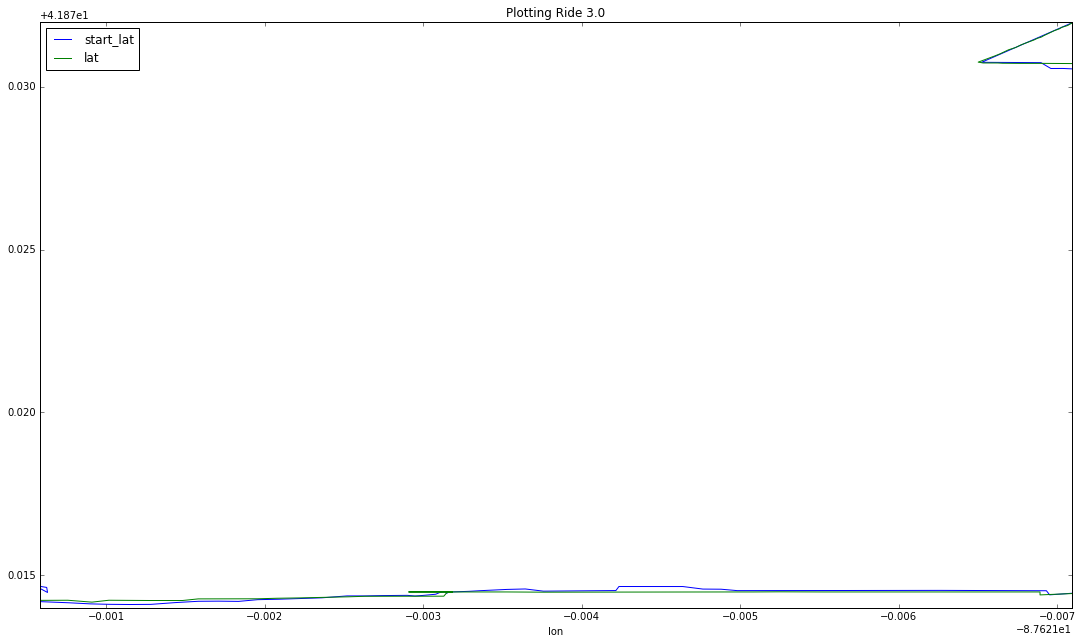

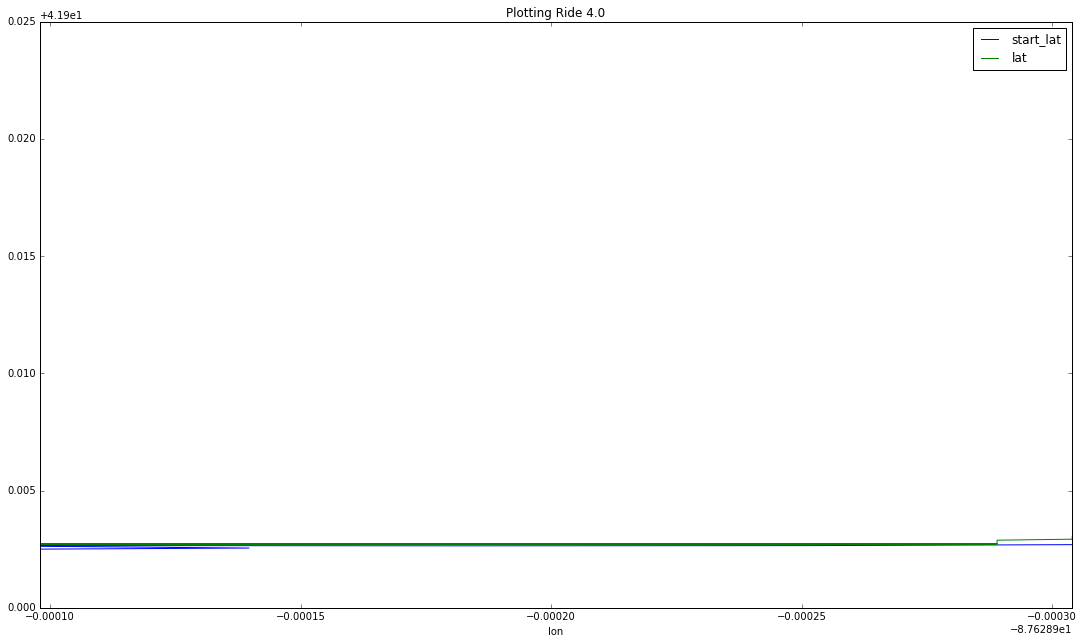

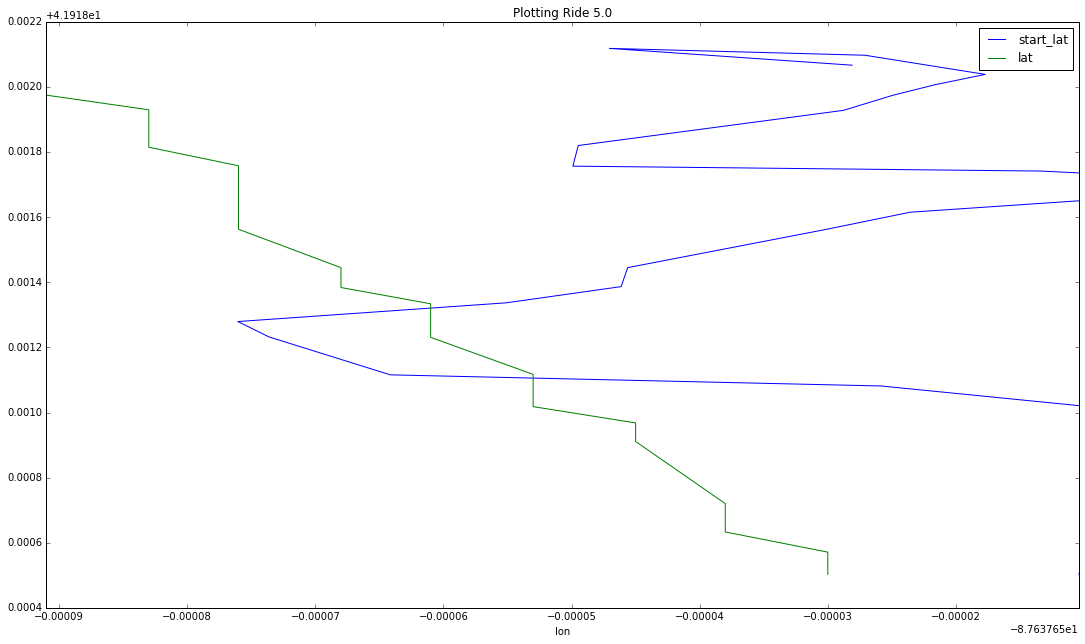

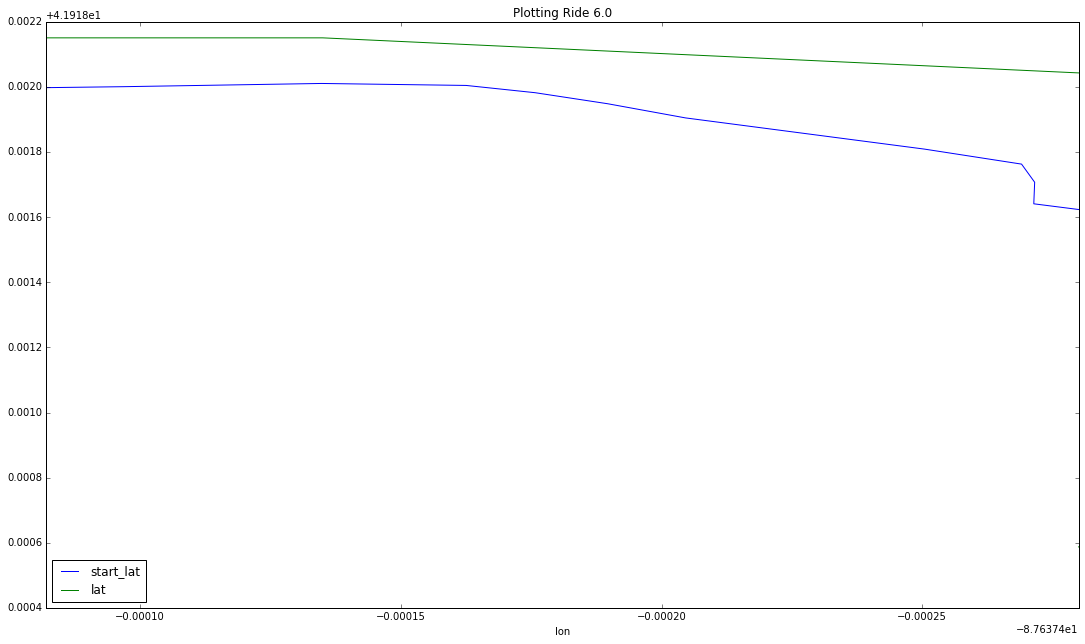

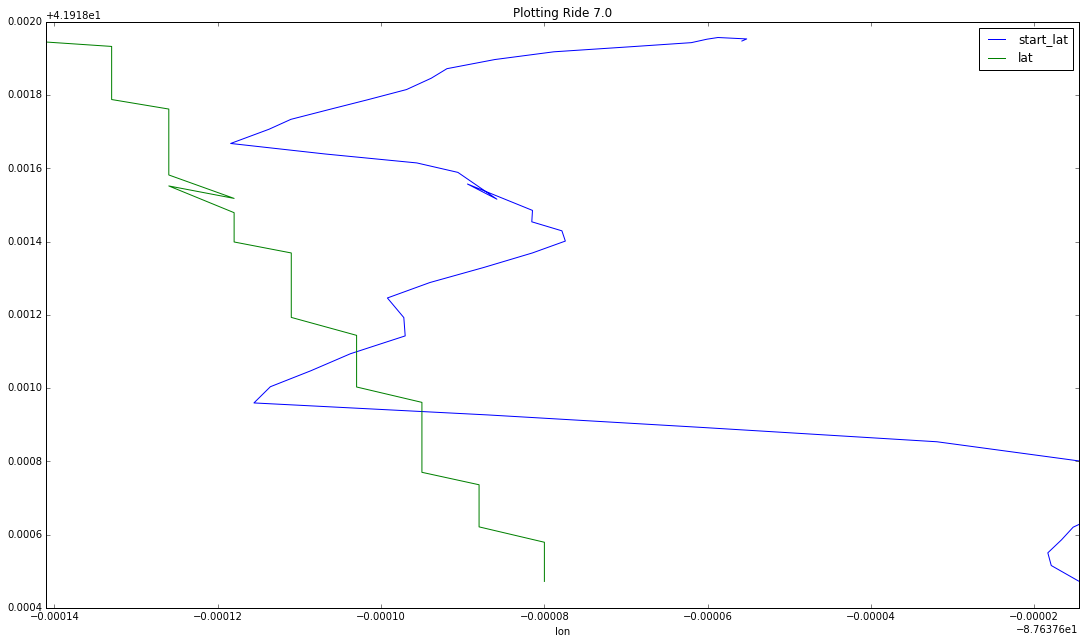

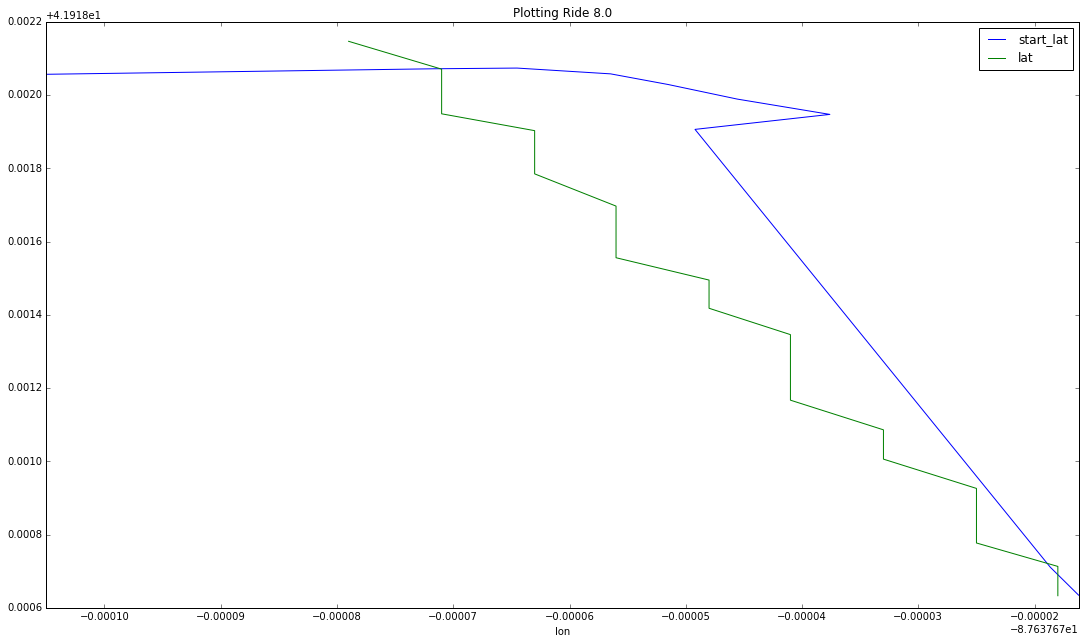

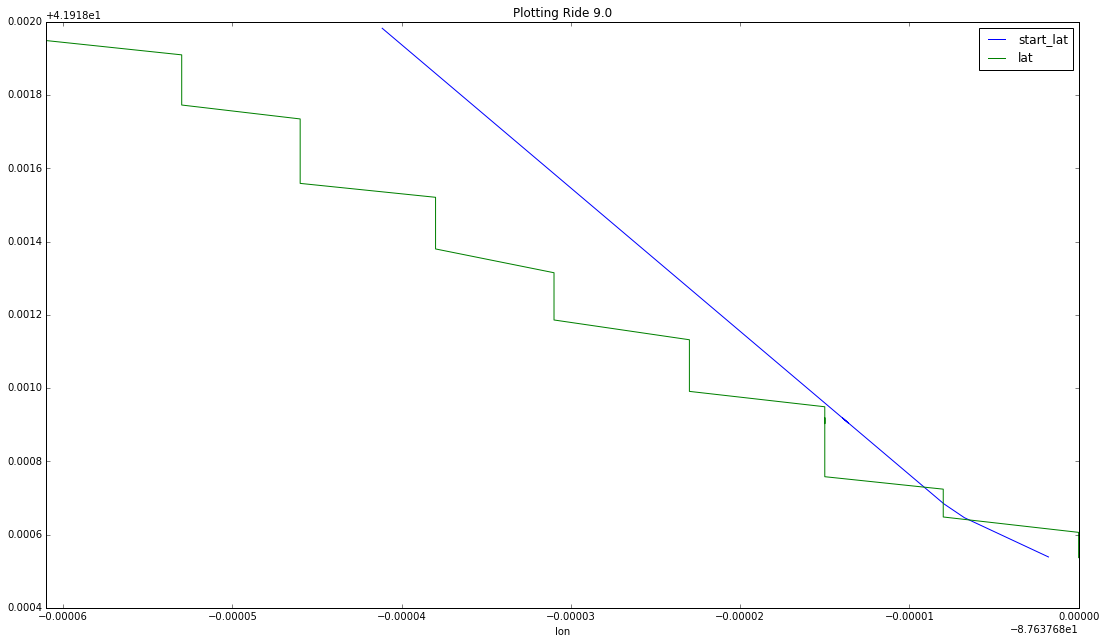

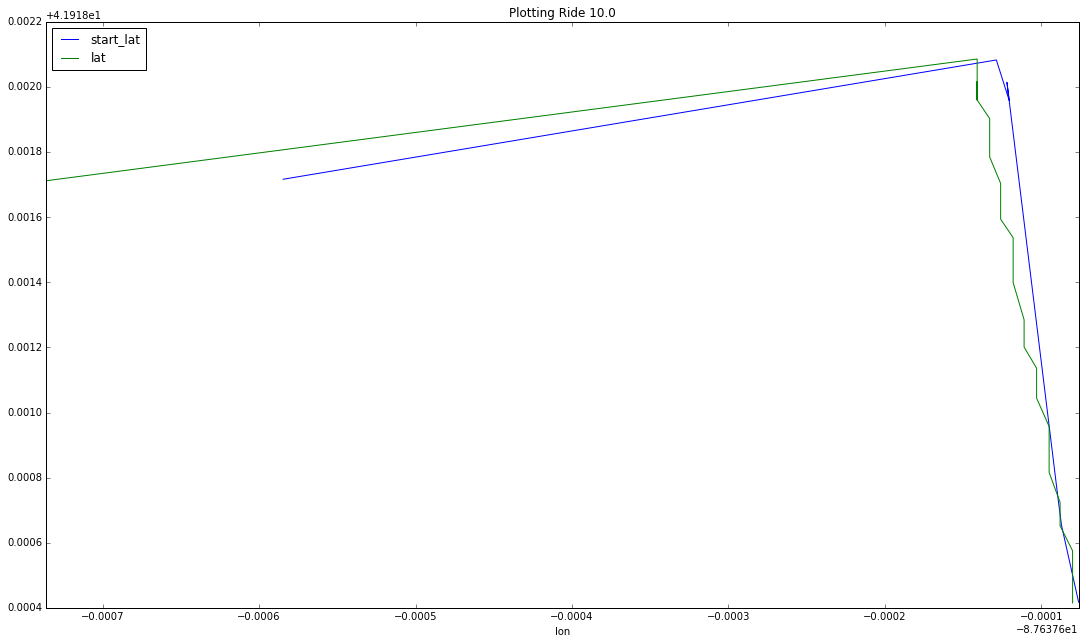

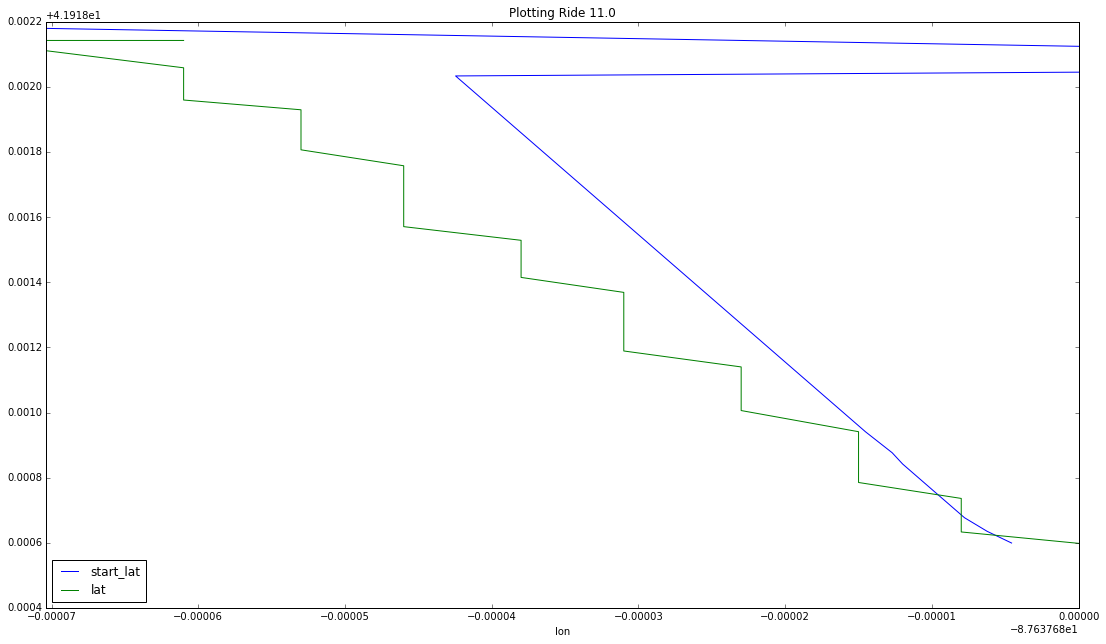

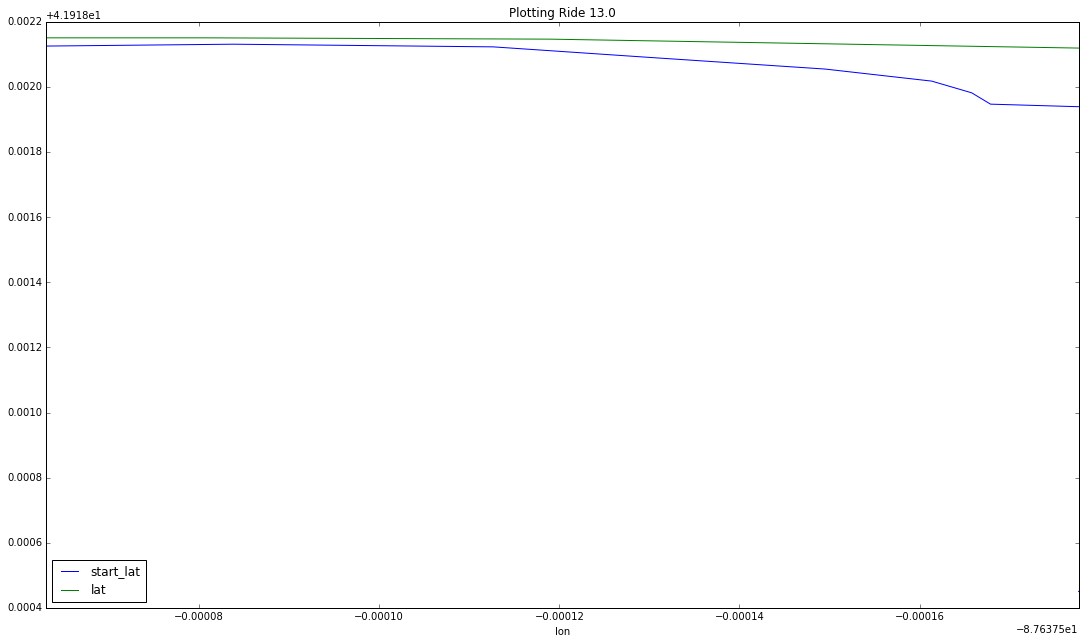

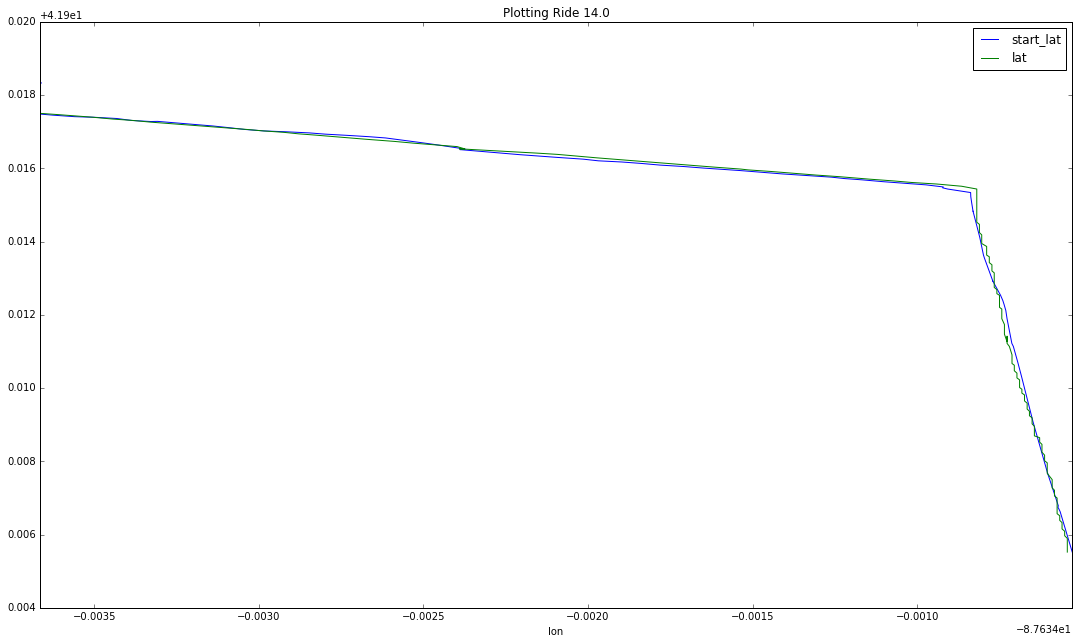

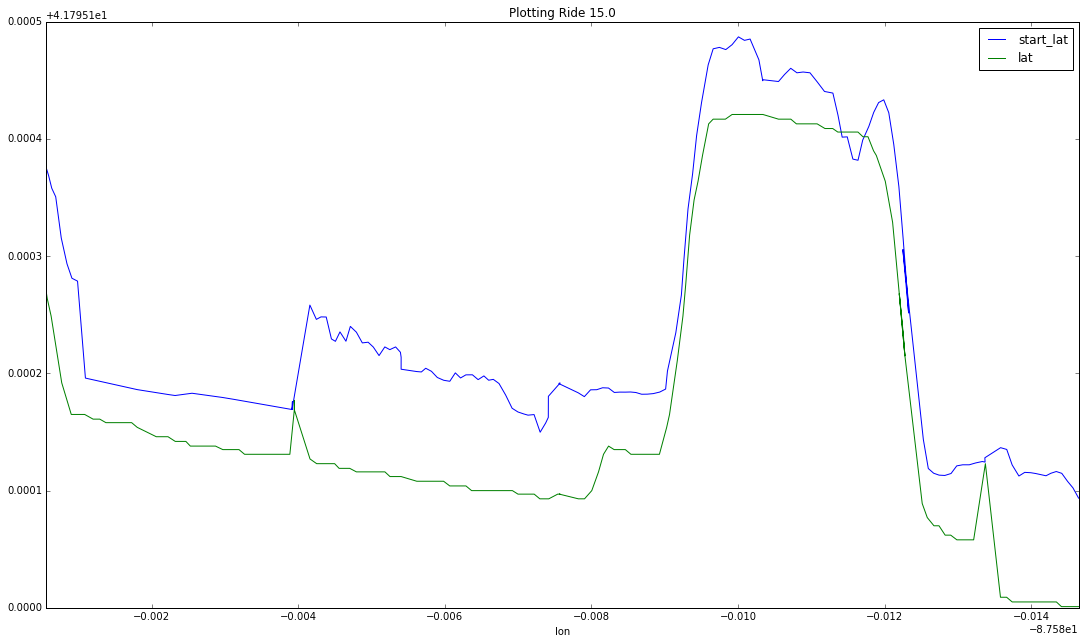

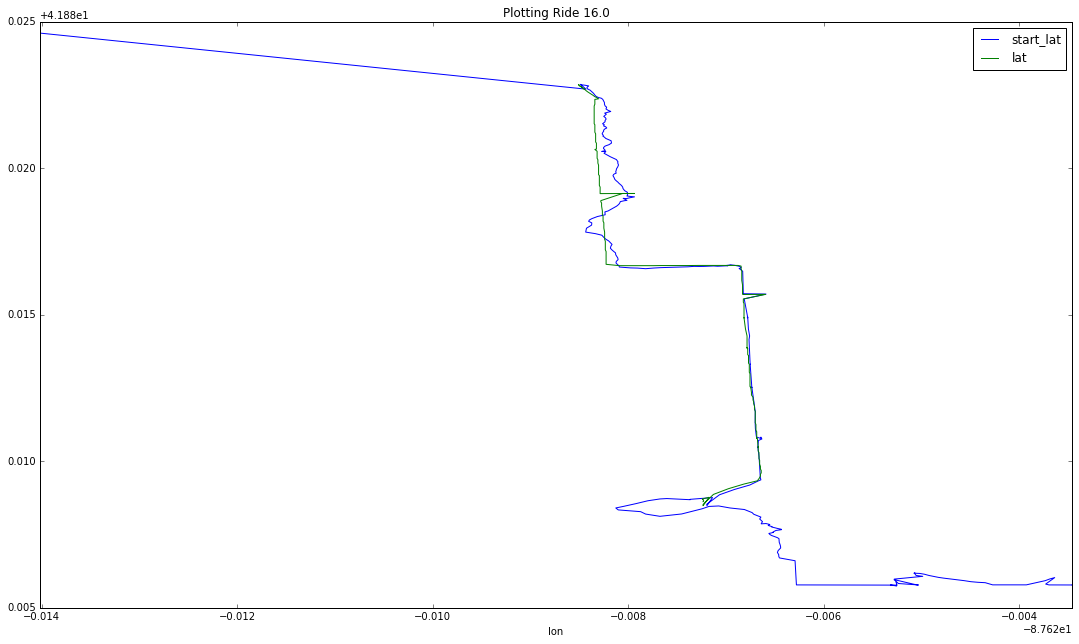

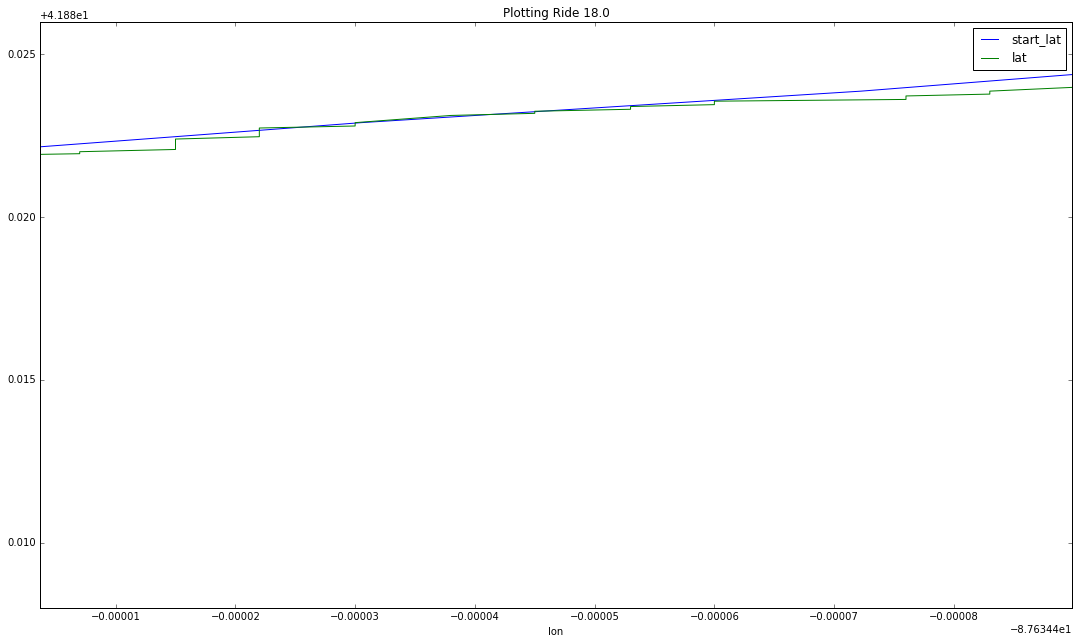

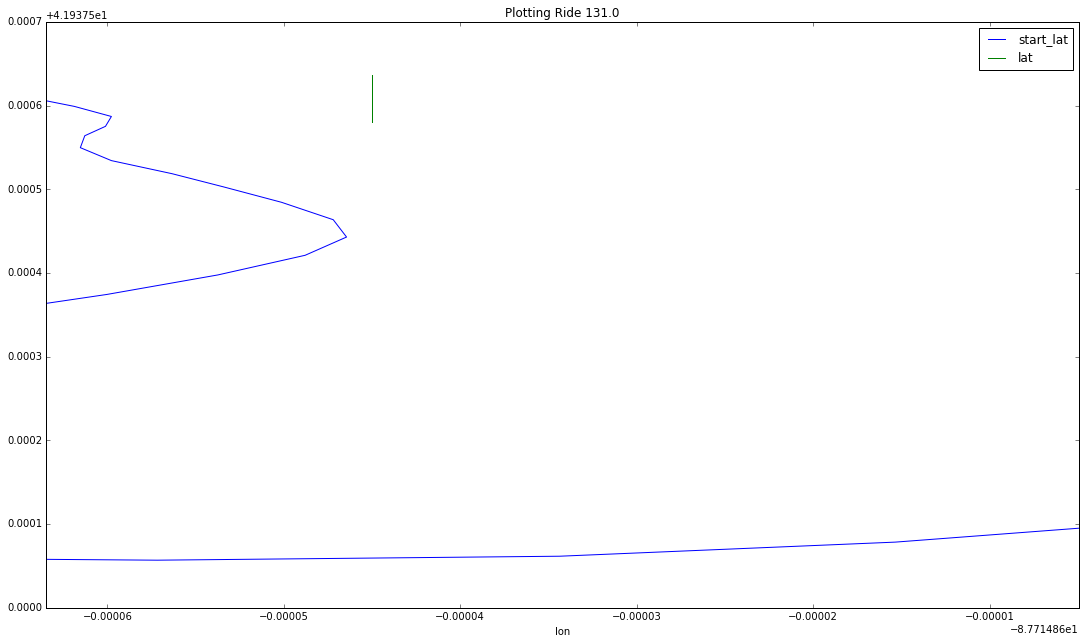

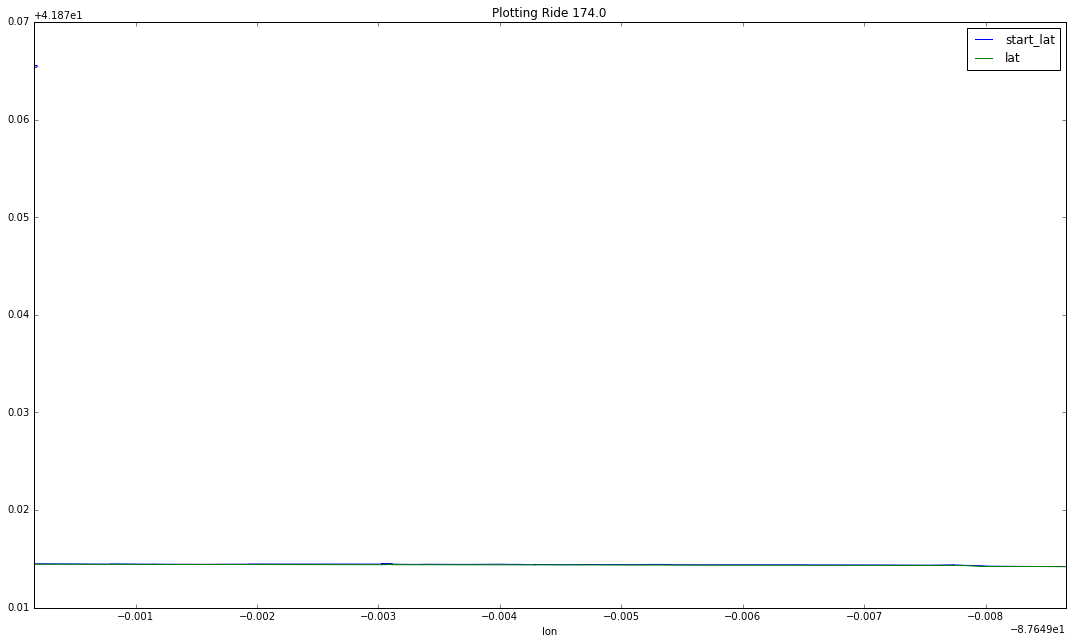

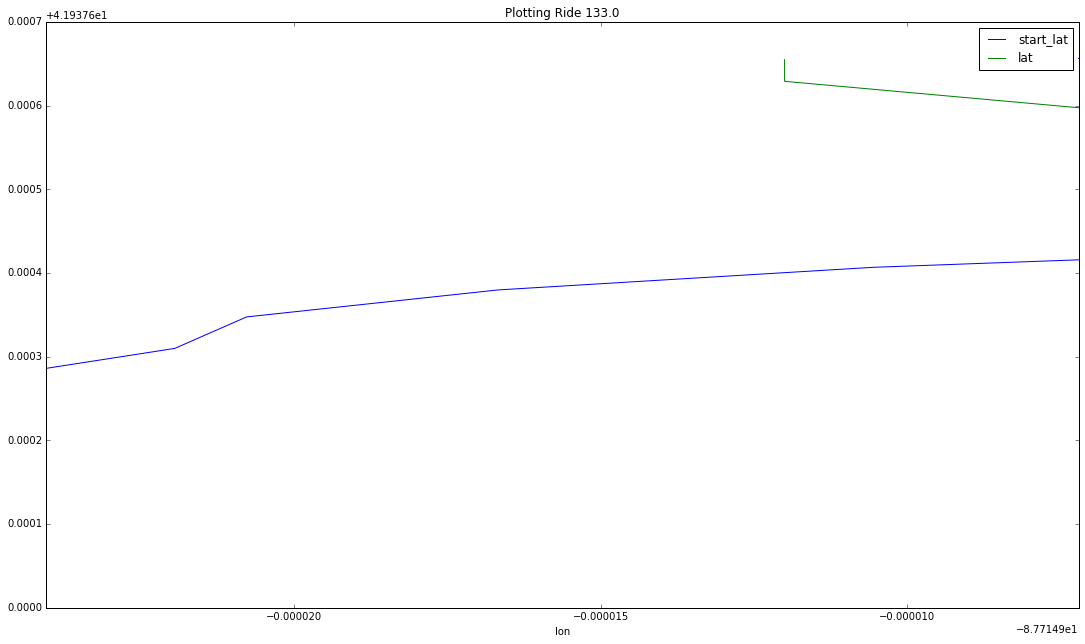

could not snap


/opt/conda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-87.6276552133, right=-87.6276552133
  'left=%s, right=%s') % (left, right))


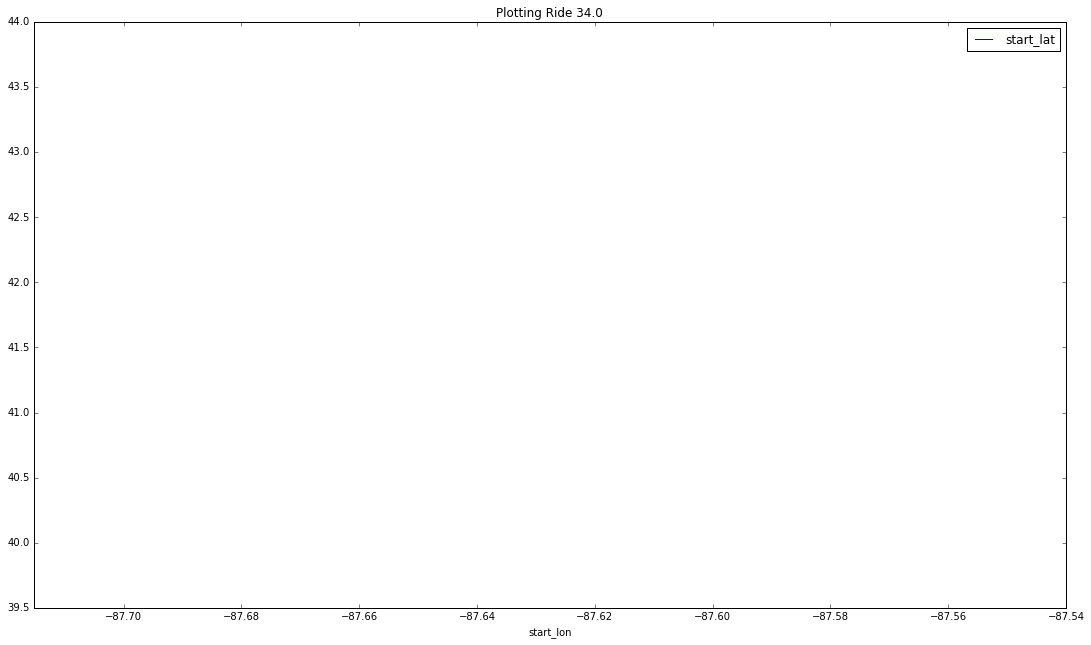

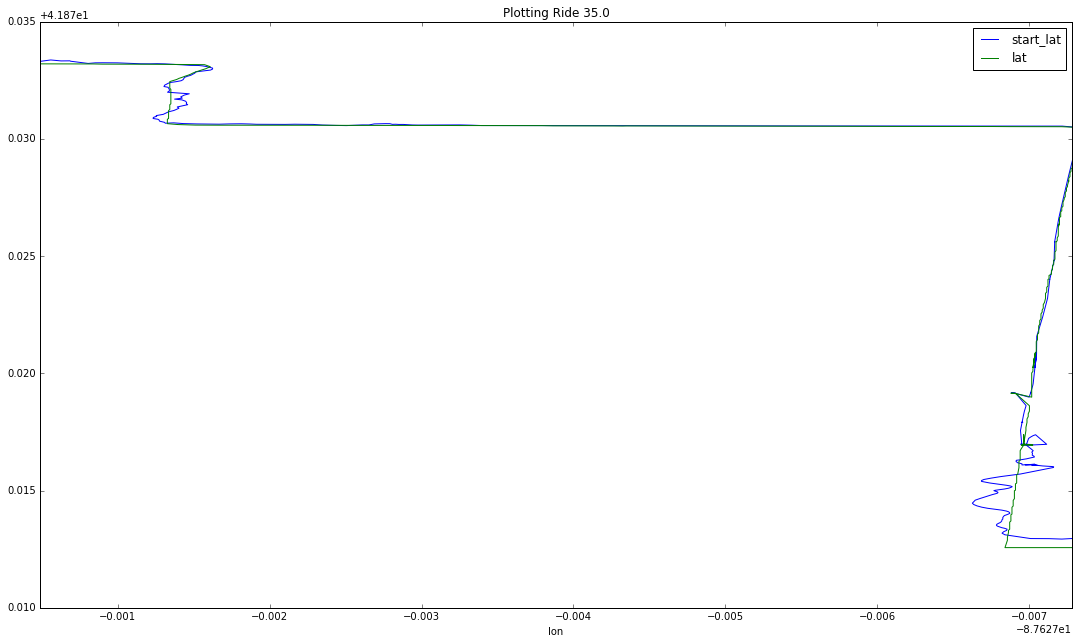

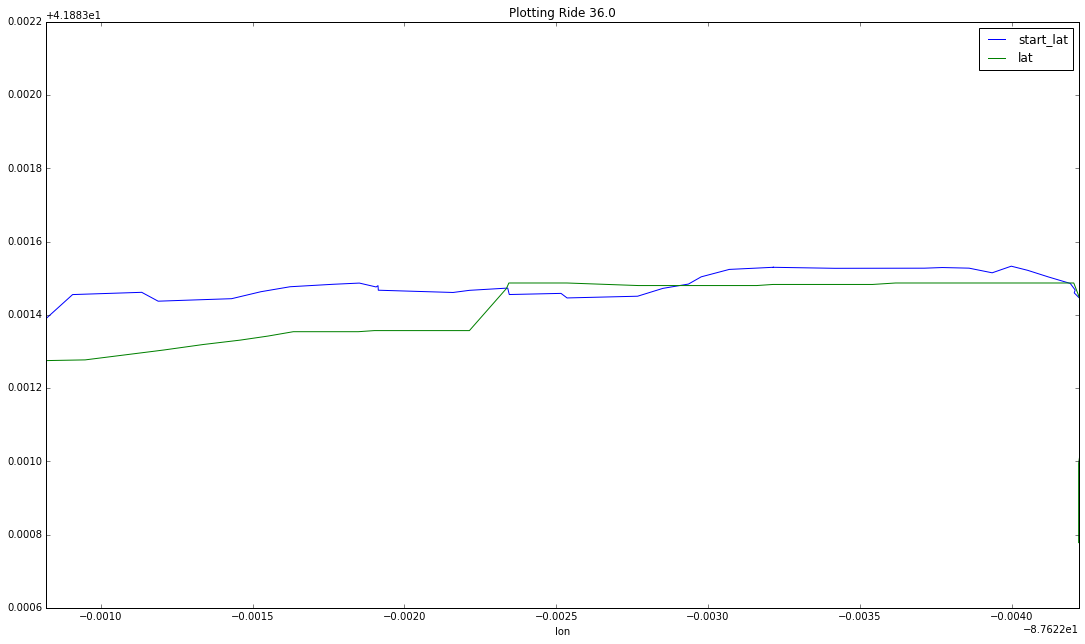

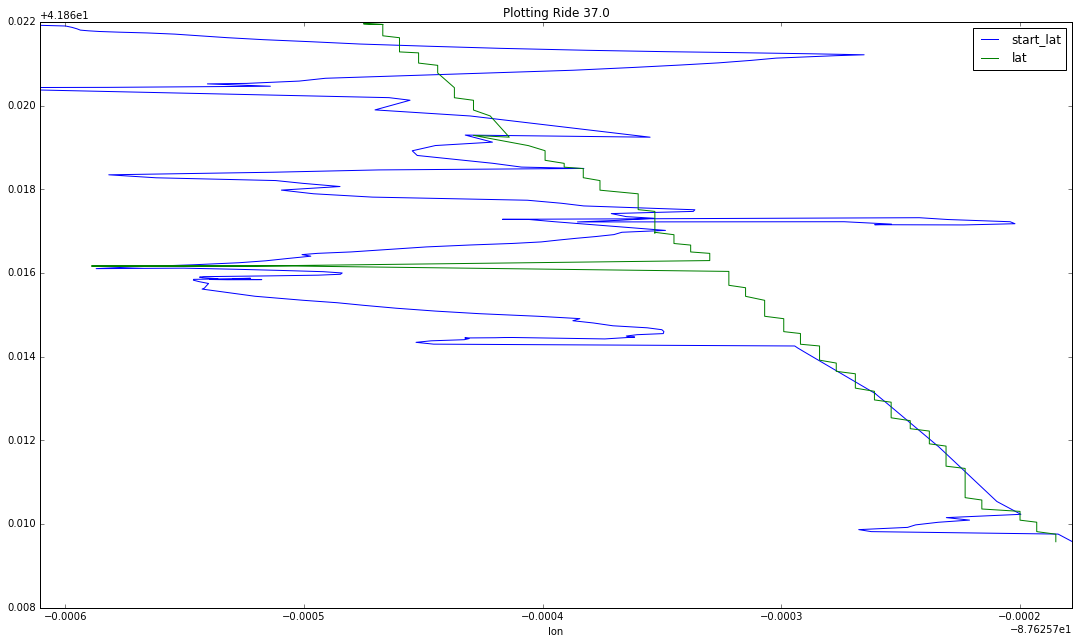

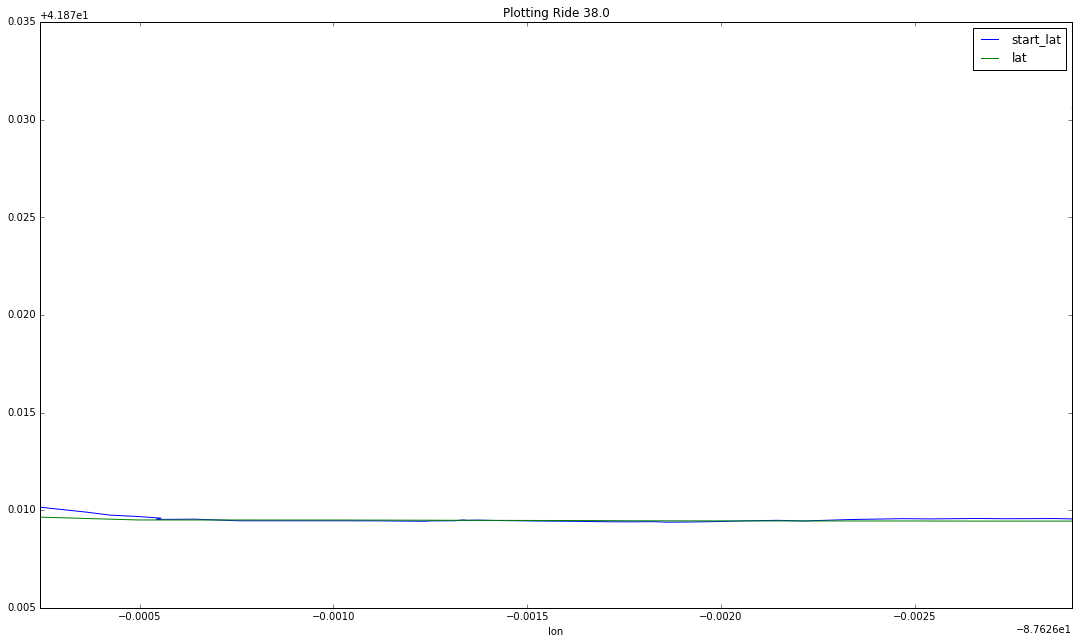

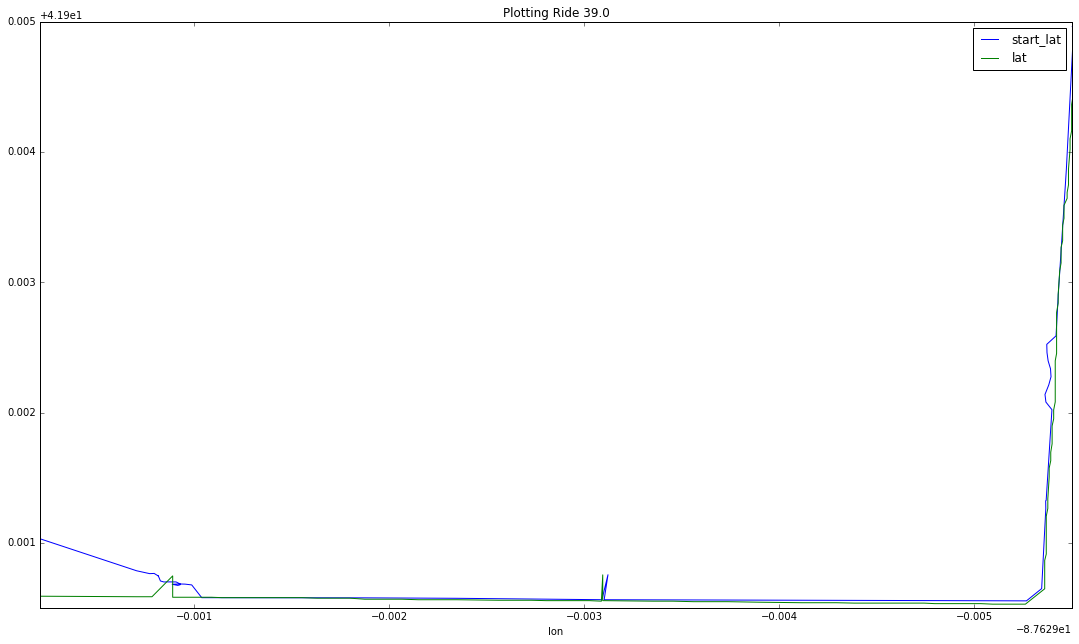

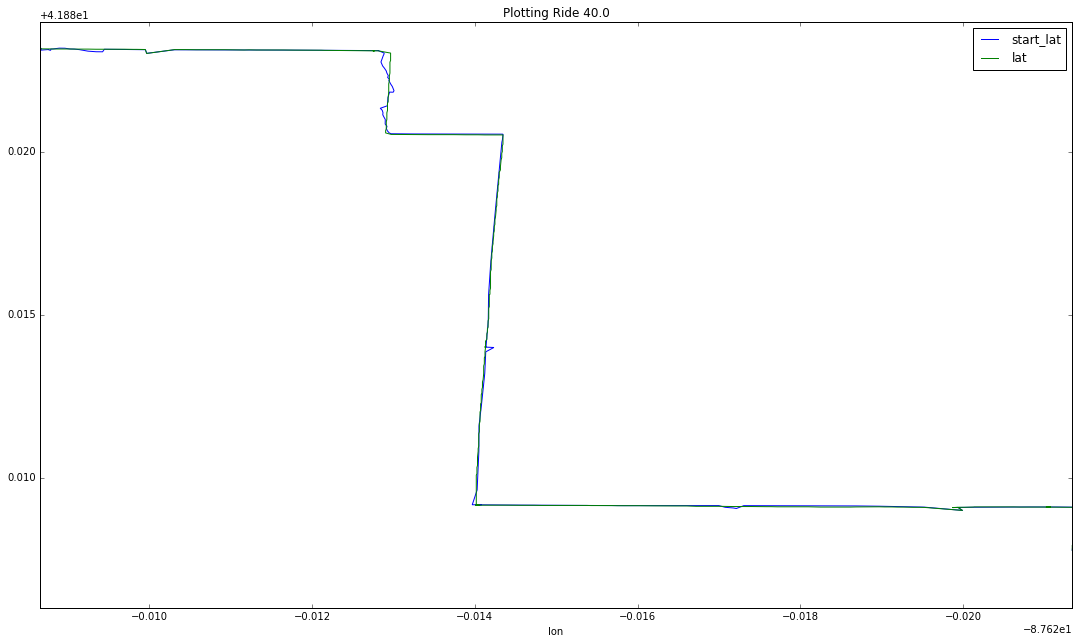

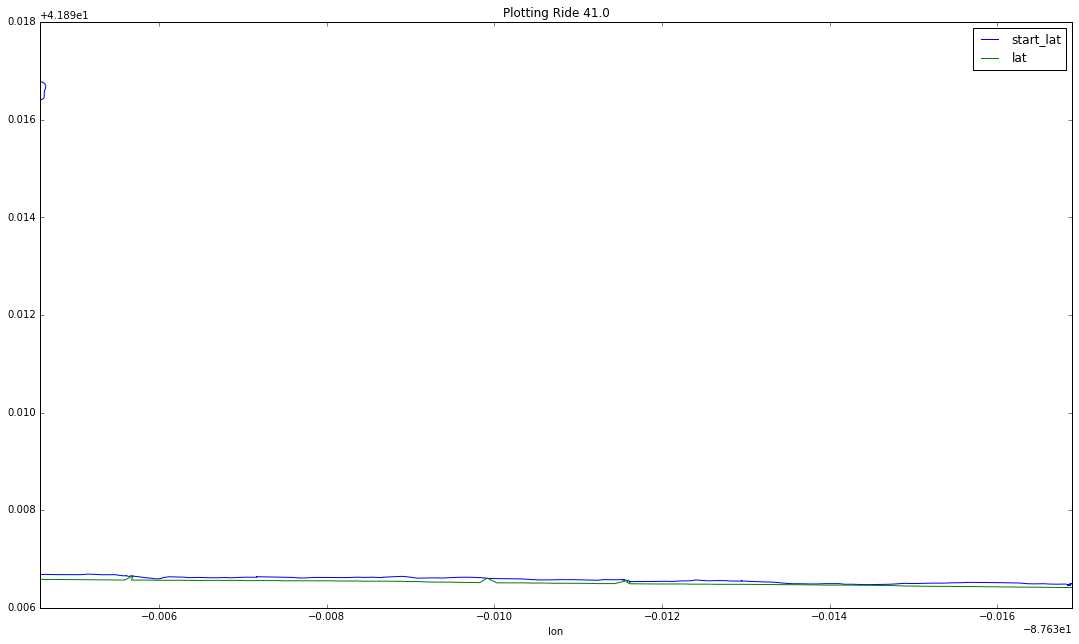

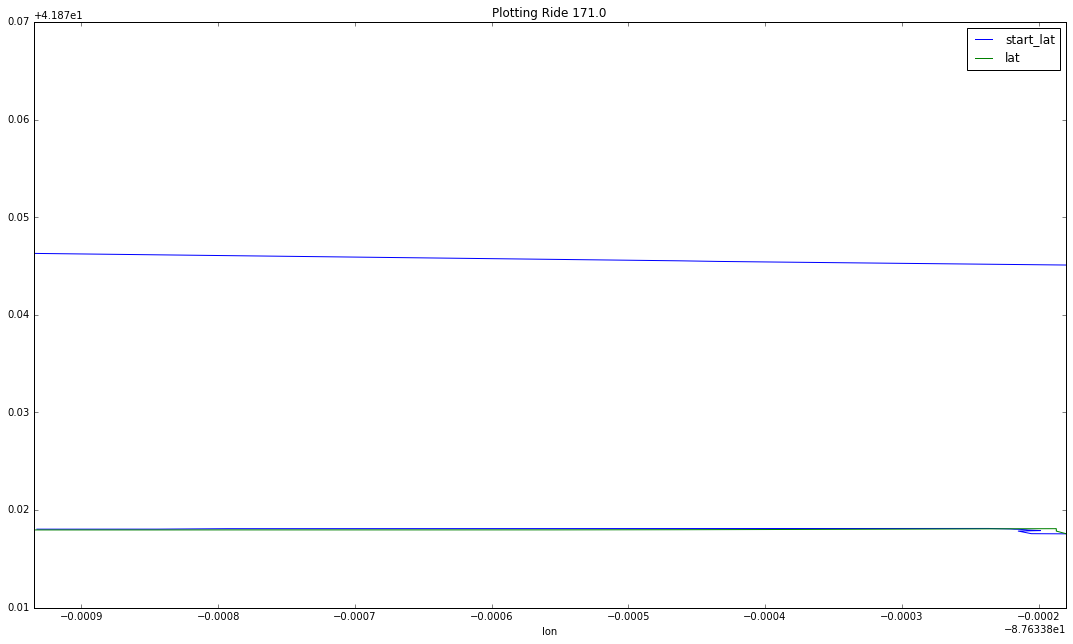

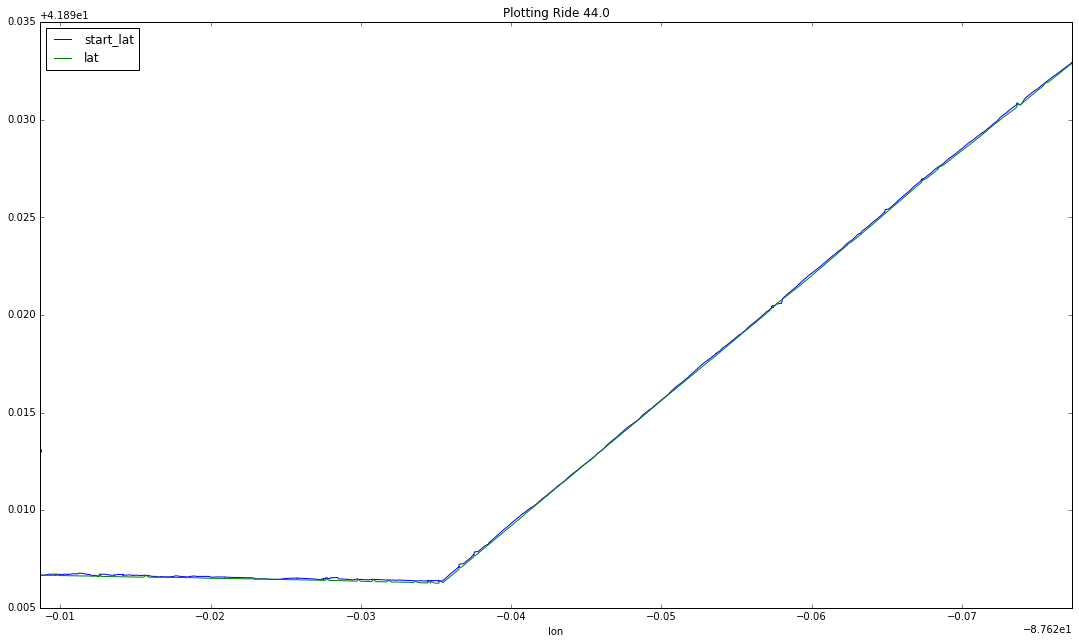

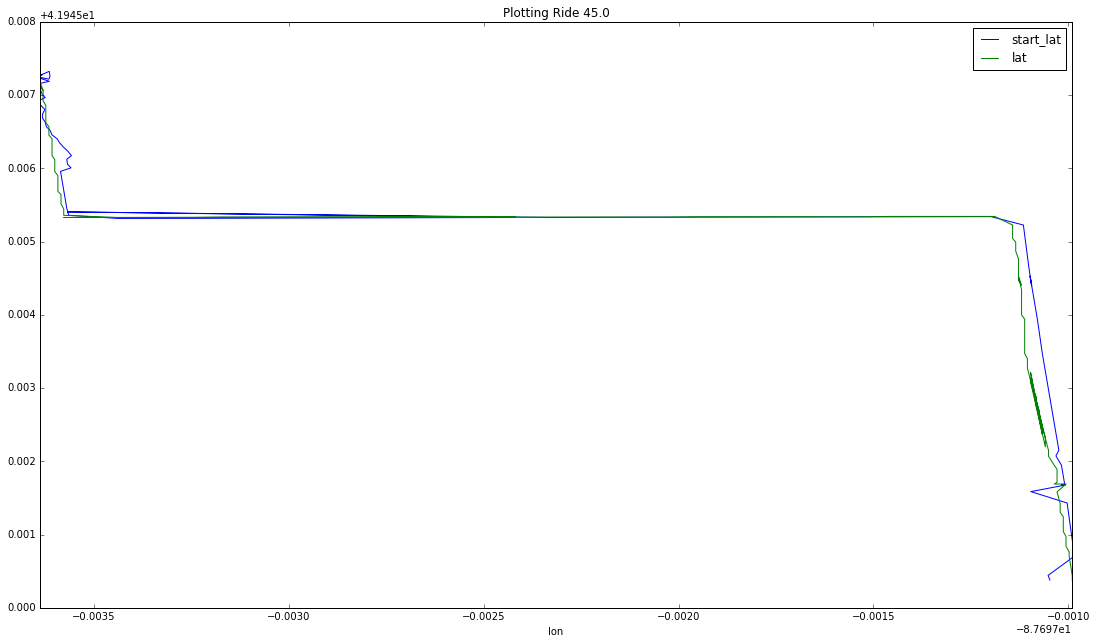

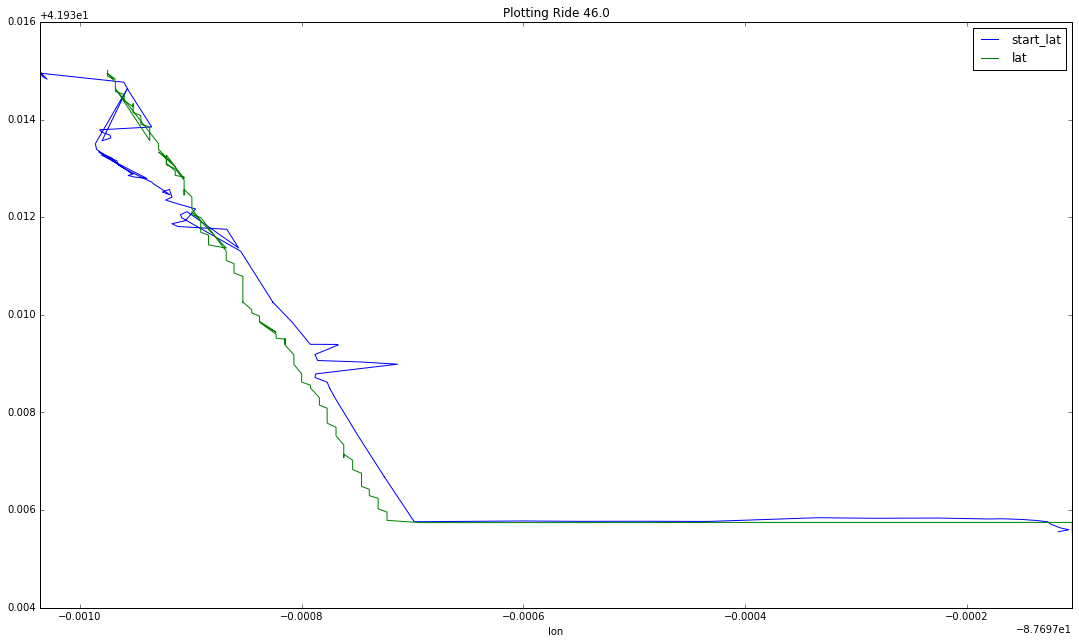

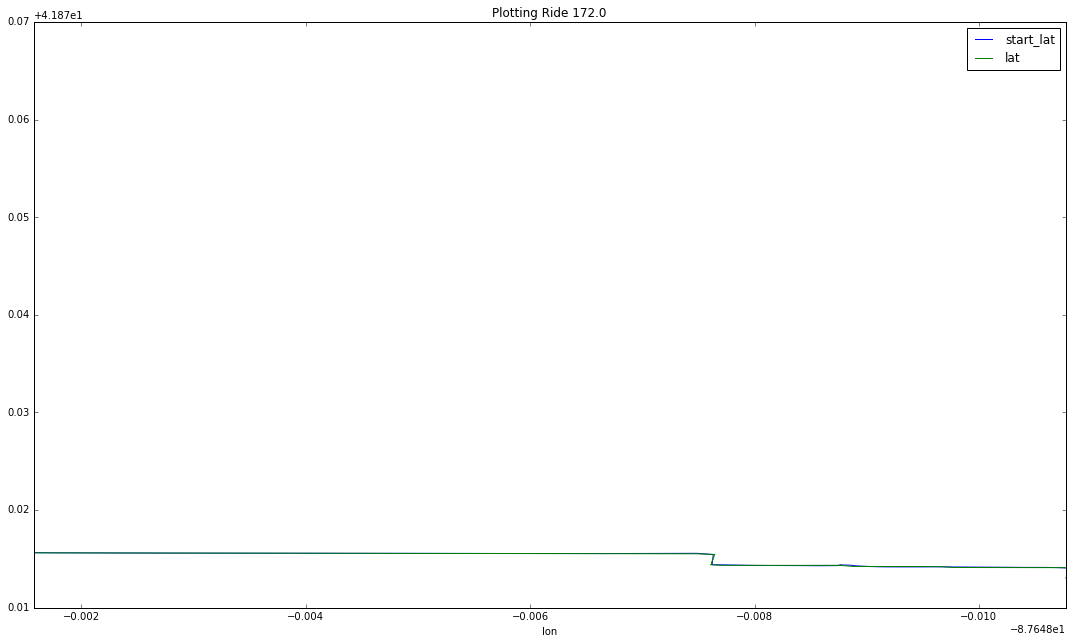

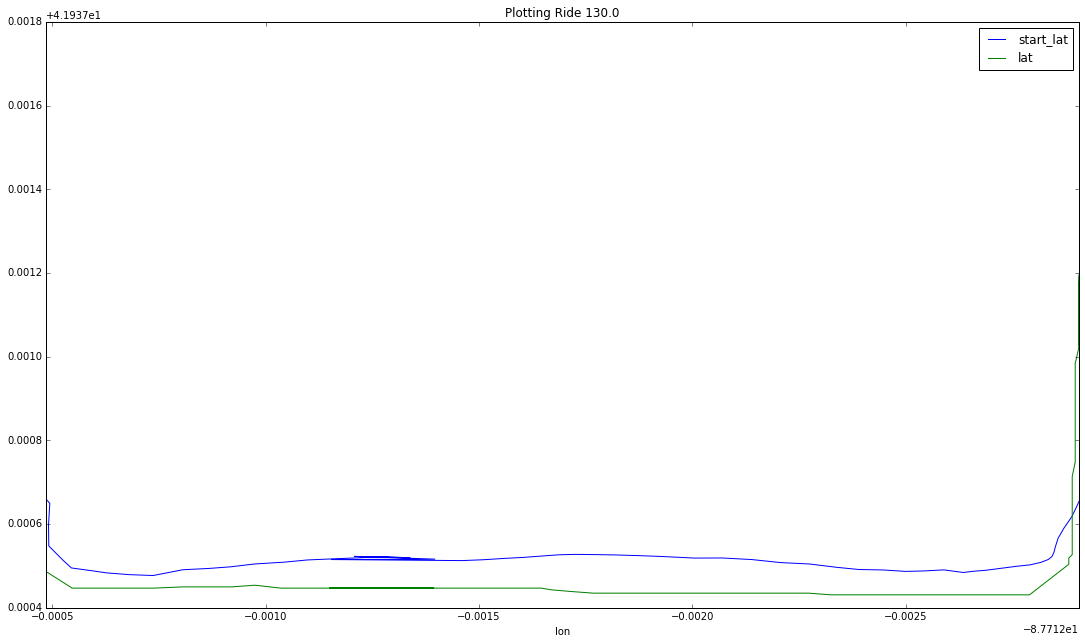

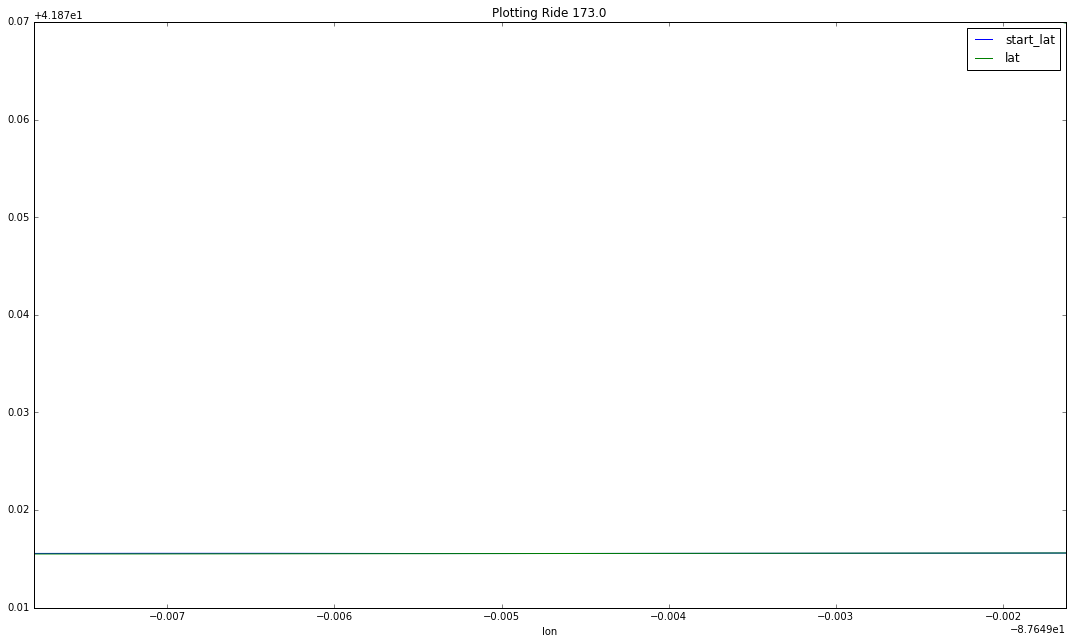

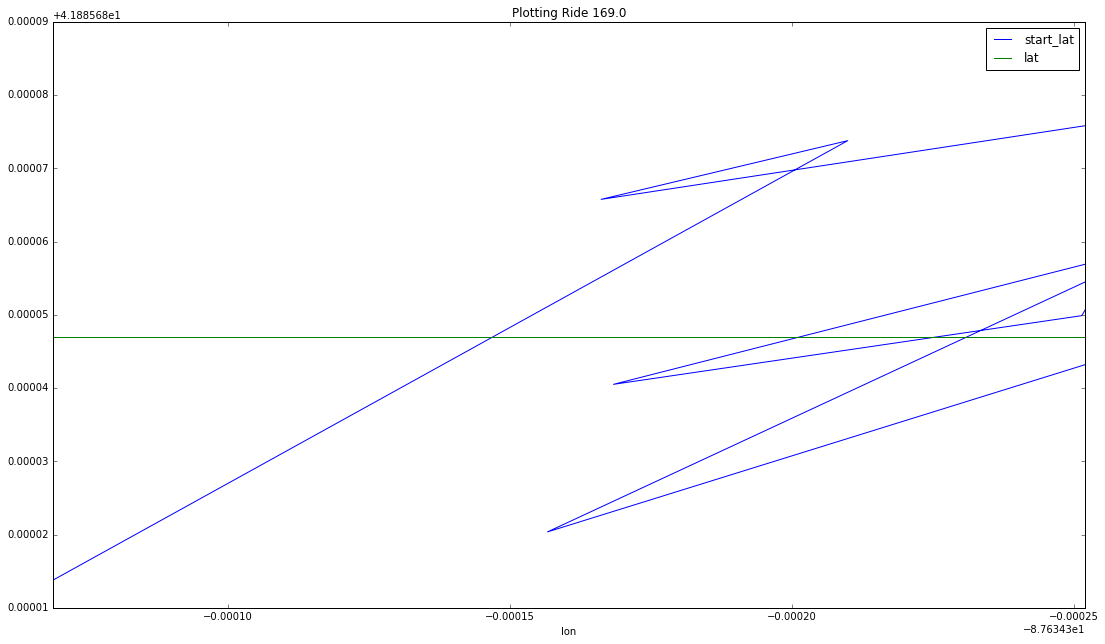

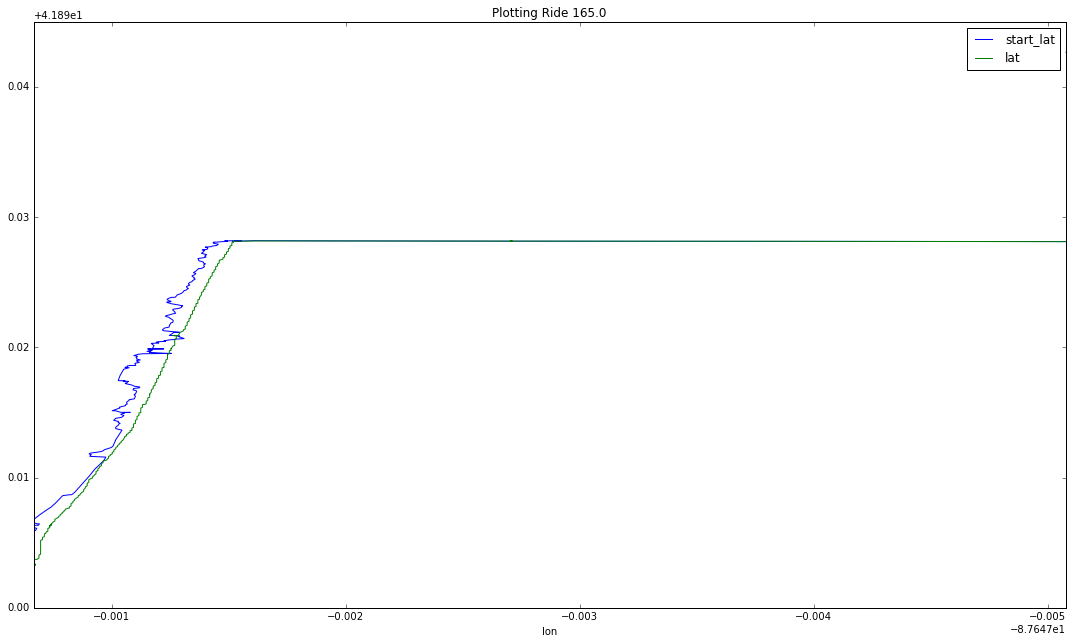

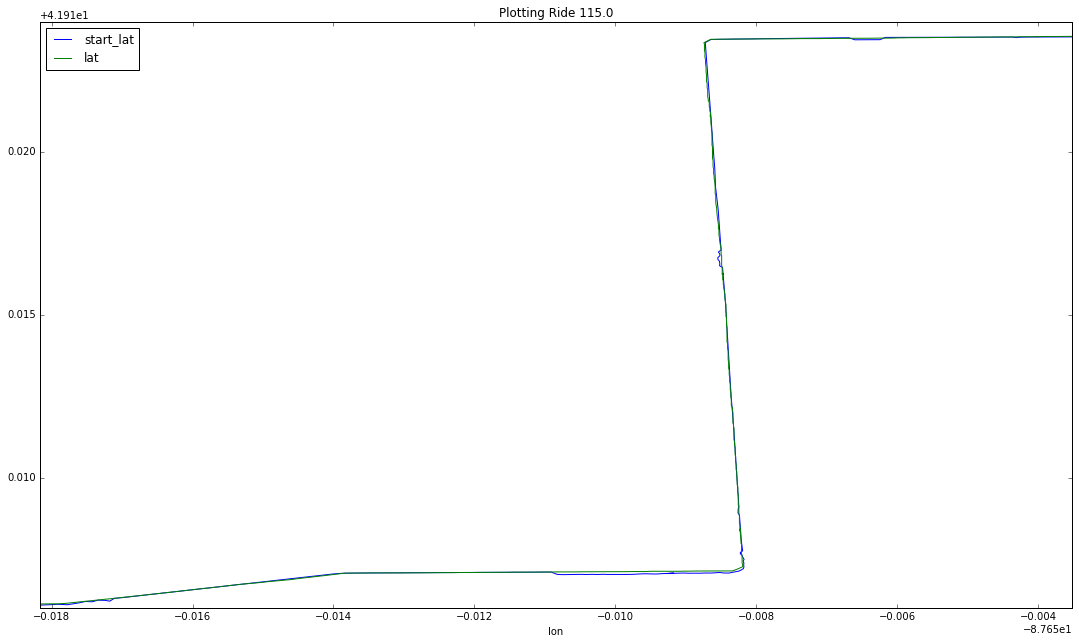

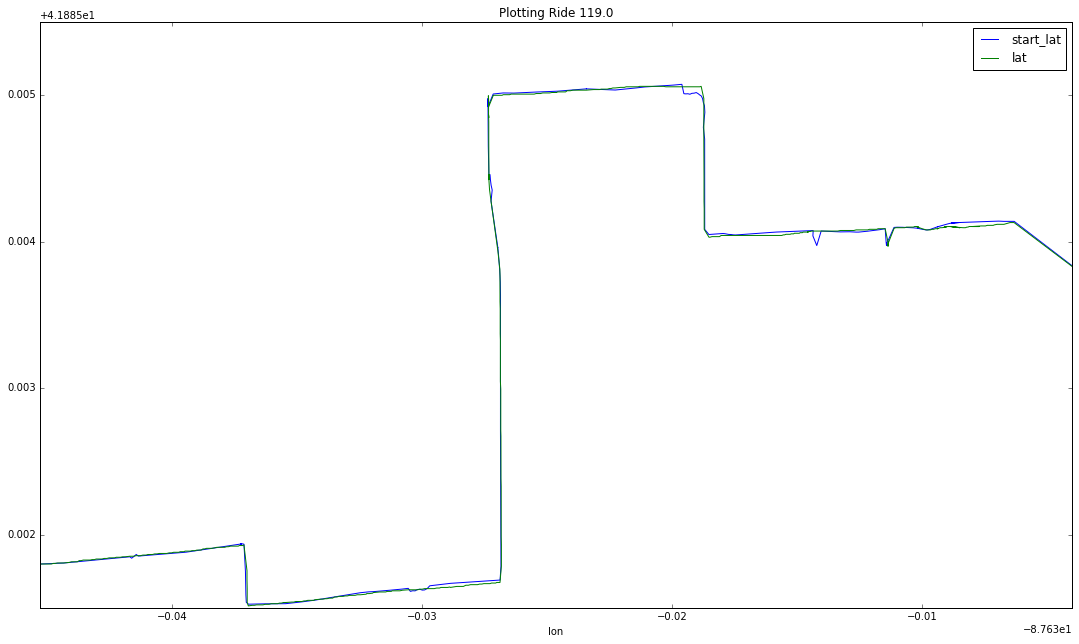

could not snap


/opt/conda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-87.6364372217, right=-87.6364372217
  'left=%s, right=%s') % (left, right))


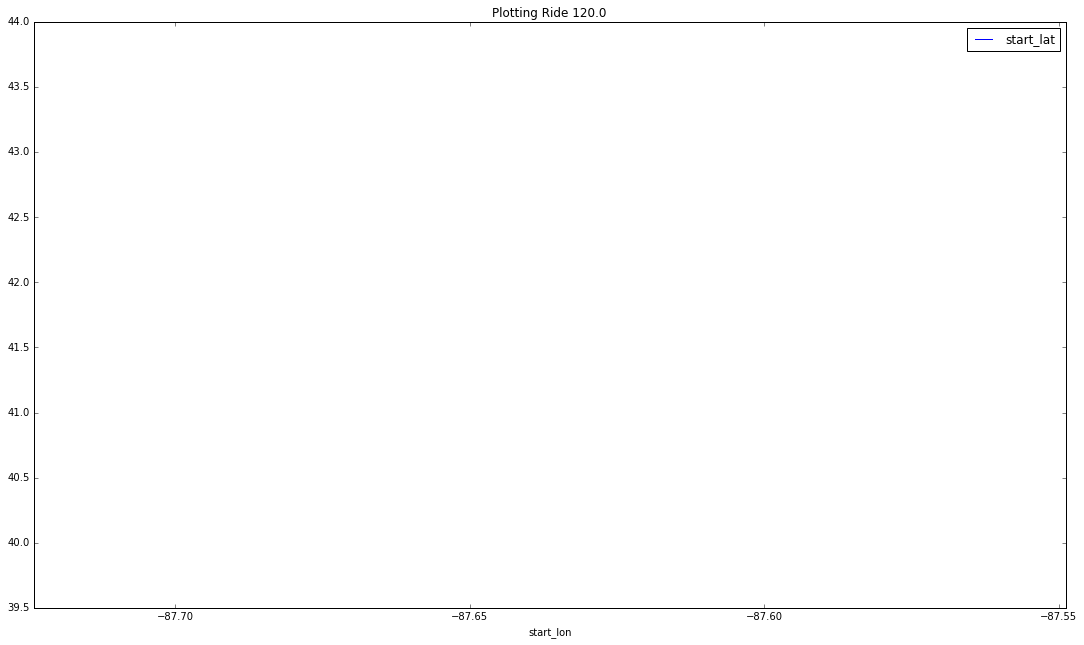

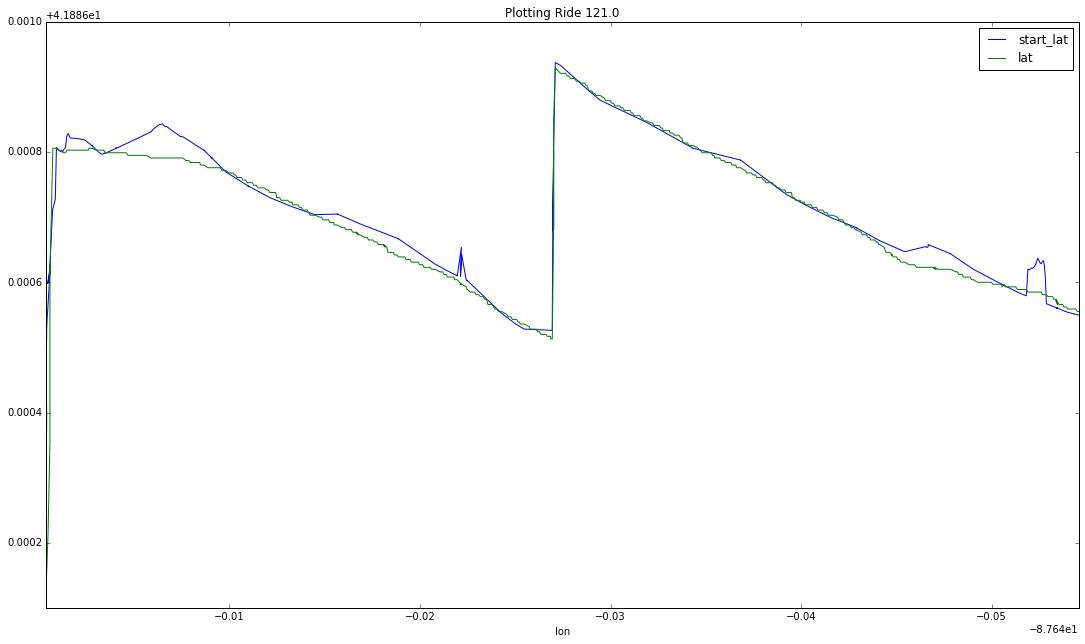

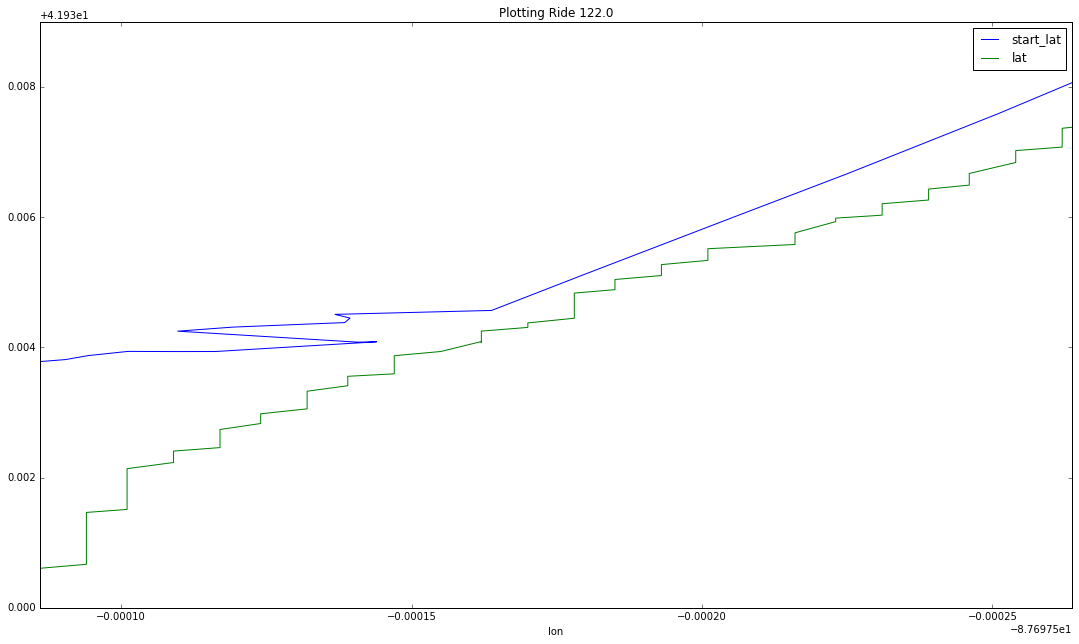

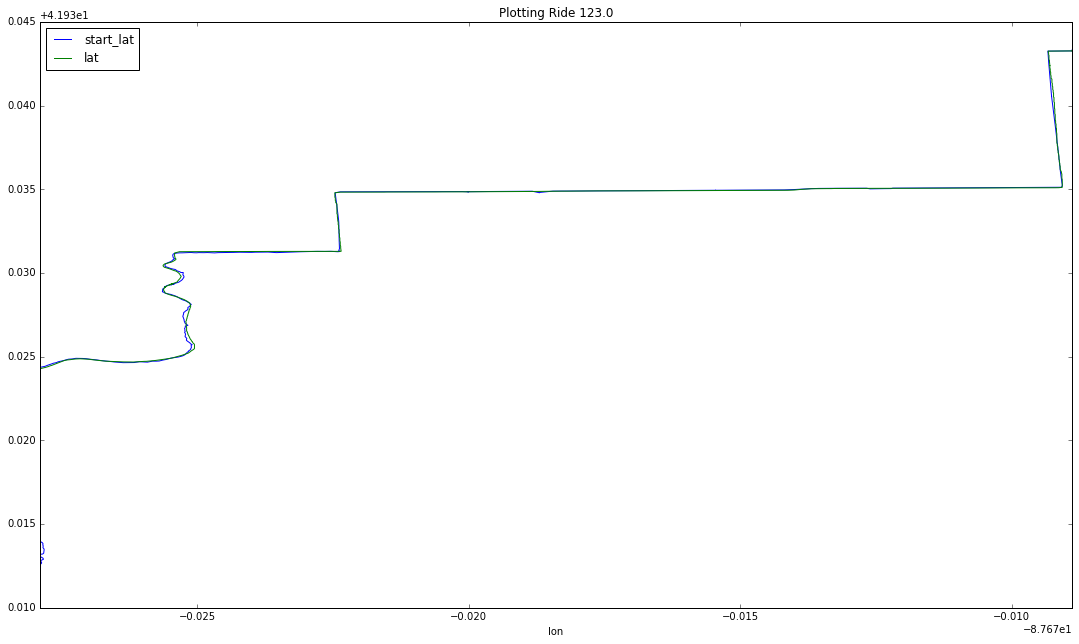

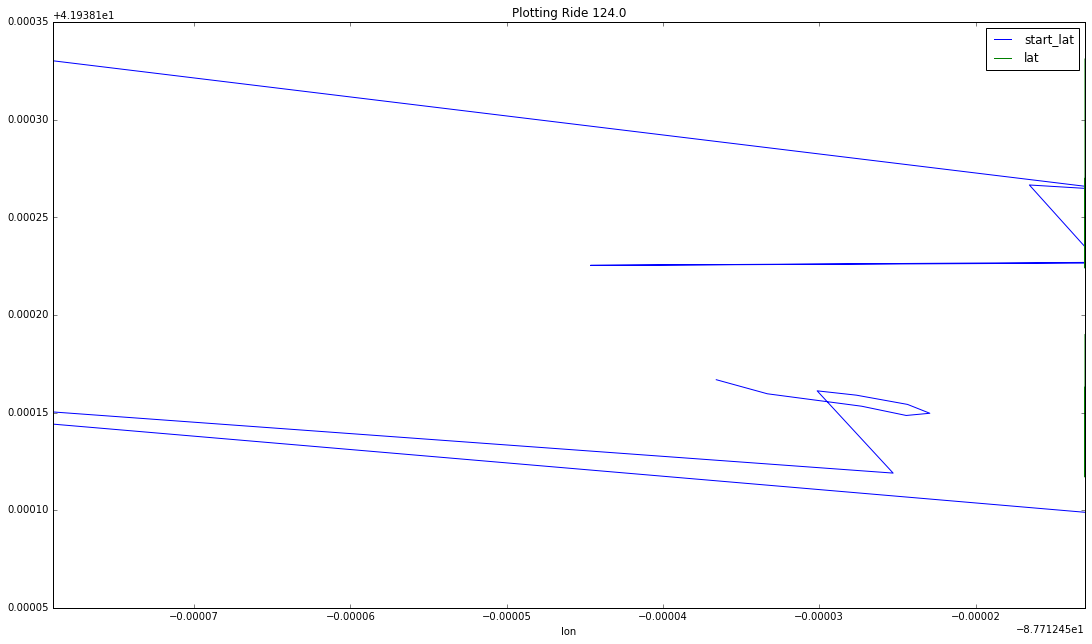

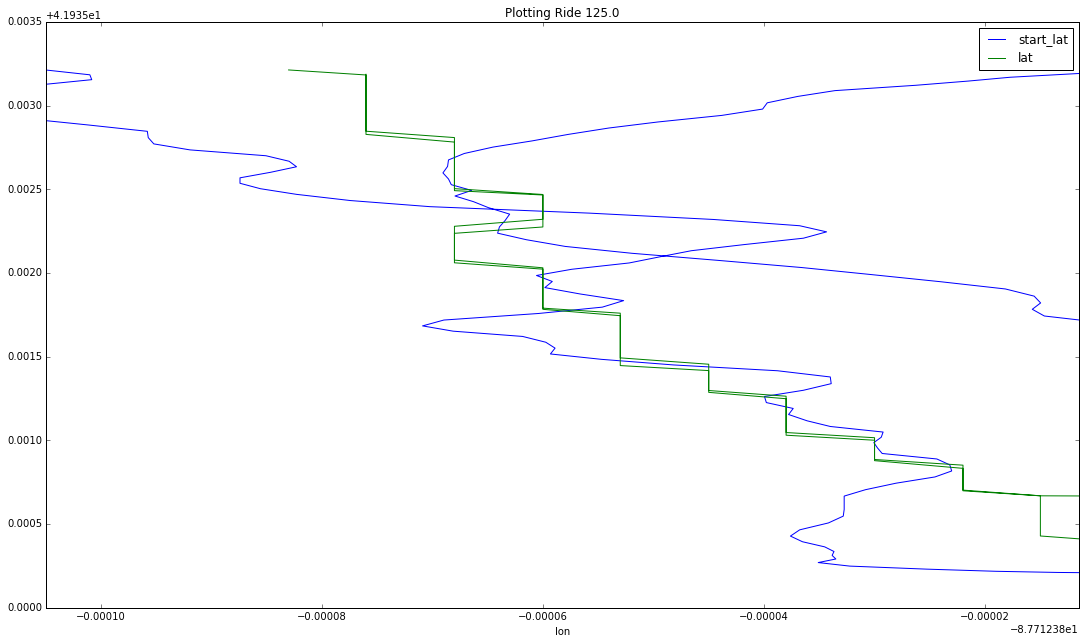

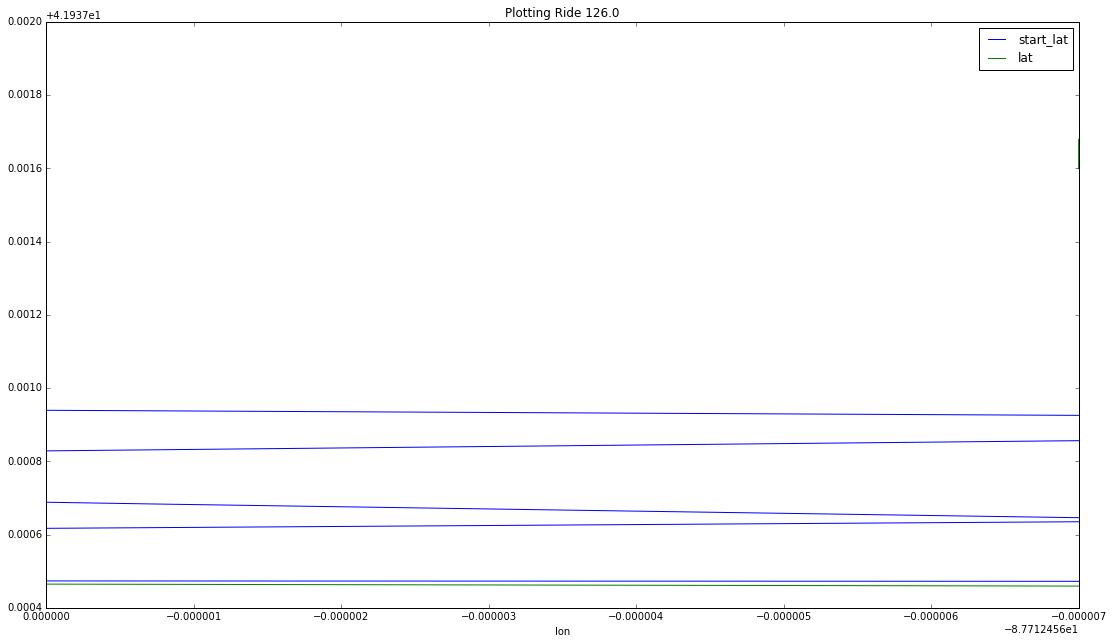

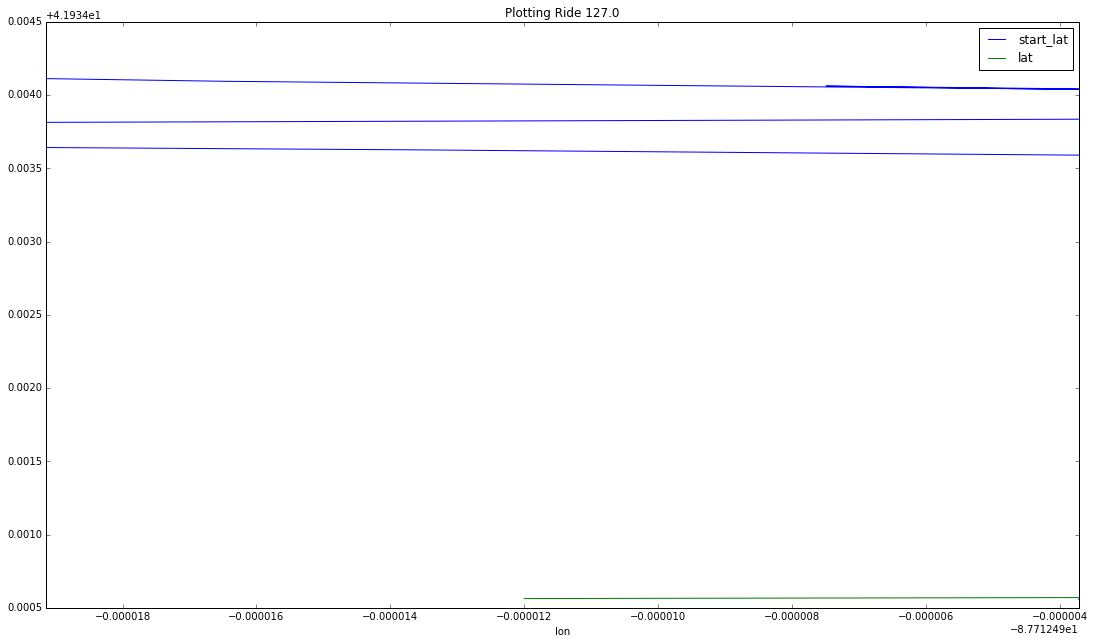

In [18]:
for ride_id in chi_rides:
    if pd.notnull(ride_id):
#         for i, reading in readings.loc[readings['ride_id'] == random_ride_id, :].iterrows():
#             ax = plt.plot([reading['start_lon'], reading['end_lon']], [reading['start_lat'], reading['end_lat']])
        ax = readings.loc[readings['ride_id'] == ride_id, :].plot(x='start_lon', y='start_lat')
        try:
            matched_ride = requests.get(readings_to_match_str(readings.loc[readings['ride_id'] == ride_id,  :])).json() 
            snapped_points =  pd.DataFrame(matched_ride['matchings'][0]['matched_points'], columns=['lat', 'lon'])
            snapped_points.plot(x='lon', y='lat', ax=ax)
        except:
            print('could not snap')
        plt.title('Plotting Ride ' + str(ride_id))
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.show()

In [19]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     print i
#     print data 
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [20]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     print i
#     print data 
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [ ]:
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     readings.loc[i, ['snapped_start_lat', 'snapped_start_lon']] = osrm_response['matchings'][0]['matched_points'][0]
#     break